In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load Toms River data
df = pd.read_excel('../raw_data/16503 - Toms River Absence History 7.1.20 to 6.30.25.xlsx')

print(f'Original data shape: {df.shape}')

# Rule 1: Filter out records where Filled = 'Unfilled' AND Needs Substitute = 'NO'
df = df[~((df['Filled'] == 'Unfilled') & (df['Needs Substitute'] == 'NO'))]
print(f'After Unfilled/NO filter: {df.shape}')

# Rule 2: Include only Employee Type = 'Teacher' or 'ESY Teacher'
df = df[df['Employee Type'].isin(['Teacher', 'ESY Teacher'])]
print(f'After Employee Type filter: {df.shape}')

df.head()


Original data shape: (384418, 13)
After Unfilled/NO filter: (256134, 13)
After Employee Type filter: (99120, 13)


,School Year,Date,Reason,Employee Identifier,Hire Date,Employee Title,Employee Type,Start Time,End Time,Duration,Absence Type,Filled,Needs Substitute
2346,2020-2021,2020-09-01,*Sick,13351,2015-06-05 13:23:53,Sped MD,Teacher,07:35:00,10:59:00,3.400000,AM Half Day,Unfilled,YES
2348,2020-2021,2020-09-01,Family Leave,14007,2015-06-05 13:23:53,(3)Sped Resource Room,Teacher,09:10:00,15:50:00,6.666666,Full Day,Unfilled,YES
2351,2020-2021,2020-09-01,Family Leave,14968,2015-06-05 13:23:53,(1)Guidance 3/5ths,Teacher,08:25:00,15:05:00,6.666666,Full Day,Filled,YES
2353,2020-2021,2020-09-01,*Sick,12904,2015-06-05 13:23:53,Math Gr 8,Teacher,07:35:00,14:25:00,6.833333,Full Day,Unfilled,YES
2354,2020-2021,2020-09-01,*Sick,14700,2015-06-05 13:23:53,Math,Teacher,07:00:00,13:50:00,6.833333,Full Day,Unfilled,YES


In [2]:
# Calculate absence days
# Full Day = 1 day, Half Day = 0.5 day, Custom Duration = use Duration column (convert to days)

def calculate_absence_days(row):
    if row['Absence Type'] == 'Full Day':
        return 1.0
    elif row['Absence Type'] in ['AM Half Day', 'PM Half Day']:
        return 0.5
    elif row['Absence Type'] == 'Custom Duration':
        # Duration is in hours, convert to days (assuming 7-8 hours per day, use 7.5 as average)
        hours = pd.to_numeric(row['Duration'], errors='coerce')
        if pd.isna(hours):
            return 0
        return hours / 7.5
    else:
        return 0

df['Absence_Days'] = df.apply(calculate_absence_days, axis=1)

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

print("Absence days calculated")
print(f"Total absence days: {df['Absence_Days'].sum():.2f}")
print(f"\nAbsence Type distribution:")
print(df.groupby('Absence Type')['Absence_Days'].agg(['sum', 'count']))



Absence days calculated
Total absence days: 90158.04

Absence Type distribution:
                          sum  count
Absence Type                        
AM Half Day       2429.500000   4859
Custom Duration    666.035545   1121
Full Day         80985.000000  80985
PM Half Day       6077.500000  12155


Total Number of Teachers by School Year:
  School Year  Total Teachers
0   2020-2021            1069
1   2021-2022            1060
2   2022-2023            1078
3   2023-2024            1067
4   2024-2025            1021


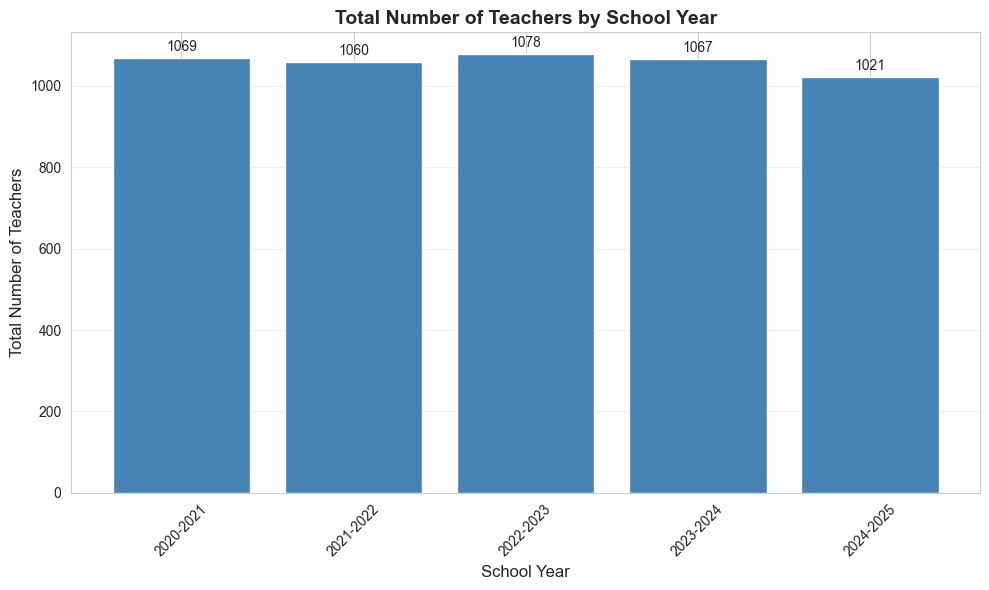

In [3]:
# Total Number of Teachers by School Year
teachers_by_year = df.groupby('School Year')['Employee Identifier'].nunique().reset_index()
teachers_by_year.columns = ['School Year', 'Total Teachers']
teachers_by_year = teachers_by_year.sort_values('School Year')

print("Total Number of Teachers by School Year:")
print(teachers_by_year)

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(teachers_by_year['School Year'], teachers_by_year['Total Teachers'], color='steelblue')
plt.title('Total Number of Teachers by School Year', fontsize=14, fontweight='bold')
plt.xlabel('School Year', fontsize=12)
plt.ylabel('Total Number of Teachers', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(teachers_by_year['Total Teachers']):
    plt.text(i, v + 10, str(int(v)), ha='center', va='bottom')
plt.tight_layout()
plt.show()



Total Number of Teacher Absences by School Year:
  School Year  Total Absences
0   2020-2021           15177
1   2021-2022           22501
2   2022-2023           21752
3   2023-2024           19783
4   2024-2025           19907


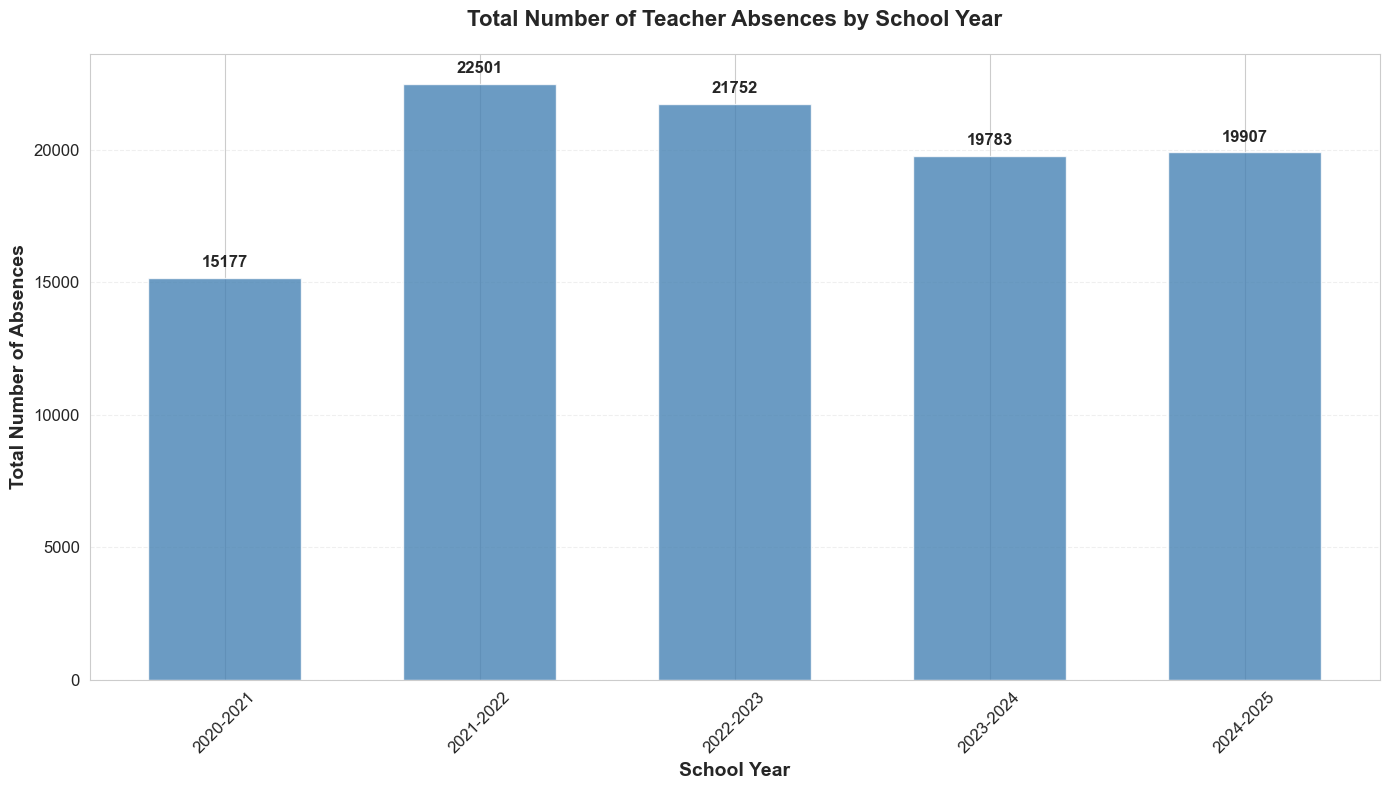

In [4]:
# Total Number of Teacher Absences by School Year - Bar Chart
absences_by_year = df.groupby('School Year').size().reset_index()
absences_by_year.columns = ['School Year', 'Total Absences']
absences_by_year = absences_by_year.sort_values('School Year')

print("Total Number of Teacher Absences by School Year:")
print(absences_by_year)

# Bar chart - separate, larger visualization
plt.figure(figsize=(14, 8))
plt.bar(absences_by_year['School Year'], absences_by_year['Total Absences'], 
        color='steelblue', width=0.6, alpha=0.8)
plt.title('Total Number of Teacher Absences by School Year', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Total Number of Absences', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(absences_by_year['Total Absences']):
    plt.text(i, v + 300, str(int(v)), ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()



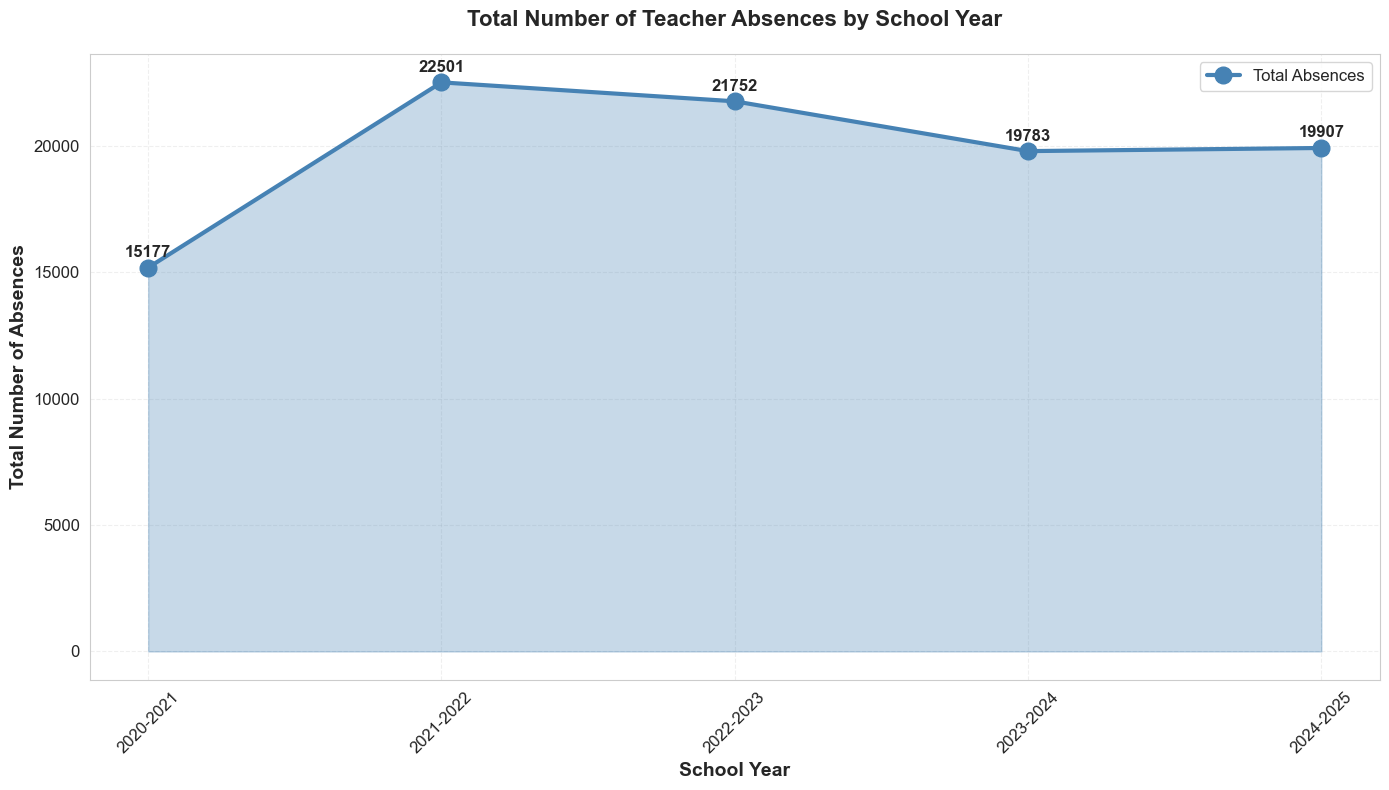

In [5]:
# Total Number of Teacher Absences by School Year - Line Chart
# Make sure absences_by_year is defined (run previous cell first if needed)
if 'absences_by_year' not in locals():
    absences_by_year = df.groupby('School Year').size().reset_index()
    absences_by_year.columns = ['School Year', 'Total Absences']
    absences_by_year = absences_by_year.sort_values('School Year')

# Line chart with area - separate, larger visualization
plt.figure(figsize=(14, 8))
plt.plot(absences_by_year['School Year'], absences_by_year['Total Absences'], 
        marker='o', linewidth=3, markersize=12, color='steelblue', label='Total Absences')
plt.fill_between(absences_by_year['School Year'], absences_by_year['Total Absences'], 
                 alpha=0.3, color='steelblue')
plt.title('Total Number of Teacher Absences by School Year', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Total Number of Absences', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
for i, v in enumerate(absences_by_year['Total Absences']):
    plt.text(i, v + 300, str(int(v)), ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()



In [6]:
# Calculate total absence days per teacher per school year
teacher_absence_days = df.groupby(['School Year', 'Employee Identifier'])['Absence_Days'].sum().reset_index()
teacher_absence_days.columns = ['School Year', 'Employee Identifier', 'Total_Days']

print(f"Total teachers with absences: {teacher_absence_days['Employee Identifier'].nunique()}")
print(f"\nSample data:")
print(teacher_absence_days.head(10))
print(f"\nSummary statistics:")
print(teacher_absence_days.groupby('School Year')['Total_Days'].describe())



Total teachers with absences: 1293

Sample data:
  School Year  Employee Identifier  Total_Days
0   2020-2021                10055         5.5
1   2020-2021                10056         7.0
2   2020-2021                10061        15.5
3   2020-2021                10077         5.0
4   2020-2021                10096         6.0
5   2020-2021                10172         8.0
6   2020-2021                10192         2.0
7   2020-2021                10195         4.0
8   2020-2021                10233        11.0
9   2020-2021                10234         5.5

Summary statistics:
              count       mean        std  min       25%   50%   75%    max
School Year                                                                
2020-2021    1069.0  12.624684  25.130713  0.5  3.844444   6.0   9.5  183.0
2021-2022    1060.0  17.946845  19.992740  1.0  9.500000  13.5  19.0  183.0
2022-2023    1078.0  16.938547  17.966603  0.5  8.500000  12.5  17.5  182.0
2023-2024    1067.0  15.666354  1

In [ ]:
# Employee Absence Days by School Year - Summary Table
# Pivot the data to show Employee Identifier as rows and School Year as columns
employee_absence_table = teacher_absence_days.pivot_table(
    index='Employee Identifier',
    columns='School Year',
    values='Total_Days',
    fill_value=0.0
).reset_index()

# Rename columns to match school year format
employee_absence_table.columns.name = None

# Calculate Total column
employee_absence_table['Total'] = employee_absence_table.select_dtypes(include=[np.number]).sum(axis=1)

# Sort by Total descending
employee_absence_table = employee_absence_table.sort_values('Total', ascending=False).reset_index(drop=True)

# Display the table
print("Employee Absence Days by School Year (Top Employees by Total Absence Days)")
print("=" * 100)
print(employee_absence_table.to_string(index=False))
print(f"\nTotal number of employees: {len(employee_absence_table)}")
print(f"\nTop 10 employees by total absence days:")
print(employee_absence_table.head(10).to_string(index=False))



Employee Absence Days by School Year (Top Employees by Total Absence Days)
 Employee Identifier  2020-2021  2021-2022  2022-2023  2023-2024  2024-2025        Total
               17685   0.000000   0.000000   0.000000        0.0   2.000000 17687.000000
               17669   0.000000   0.000000   0.000000        0.0   3.000000 17672.000000
               17660   0.000000   0.000000   0.000000        0.0   8.000000 17668.000000
               17661   0.000000   0.000000   0.000000        0.0   2.500000 17663.500000
               17650   0.000000   0.000000   0.000000        0.0   3.500000 17653.500000
               17571   0.000000   0.000000   0.000000        0.0  21.500000 17592.500000
               17586   0.000000   0.000000   0.000000        0.0   2.000000 17588.000000
               17538   0.000000   0.000000   0.000000        0.0  14.000000 17552.000000
               17537   0.000000   0.000000   0.000000        0.0  10.500000 17547.500000
               17533   0.000000   0

In [ ]:
# Analysis for different absence day thresholds
# Toms River substitute cost: $132.30 per day
SUBSTITUTE_COST_PER_DAY = 132.30

thresholds = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
results = {}

for threshold in thresholds:
    # Filter teachers with >threshold days per school year
    teachers_above_threshold = teacher_absence_days[teacher_absence_days['Total_Days'] > threshold].copy()
    
    # Get total teachers per year
    total_teachers = teacher_absence_days.groupby('School Year')['Employee Identifier'].nunique()
    
    # Get teachers above threshold per year
    teachers_above = teachers_above_threshold.groupby('School Year')['Employee Identifier'].nunique()
    
    # Get total days from teachers above threshold per year
    total_days_above = teachers_above_threshold.groupby('School Year')['Total_Days'].sum()
    
    # Calculate percentage
    pct_teachers = (teachers_above / total_teachers * 100).fillna(0)
    
    # Store results
    results[threshold] = {
        'total_teachers': total_teachers,
        'teachers_above': teachers_above,
        'total_days_above': total_days_above,
        'pct_teachers': pct_teachers
    }
    
    print(f"\n=== Threshold: >{threshold} Days ===")
    print(f"Total teachers with >{threshold} days: {len(teachers_above_threshold)}")
    print(f"\nBy School Year:")
    summary = pd.DataFrame({
        'Total Teachers': total_teachers,
        f'Teachers (>{threshold} days)': teachers_above,
        f'Total Days (>{threshold} days)': total_days_above,
        f'% of Teachers': pct_teachers
    }).fillna(0)
    print(summary)




=== Threshold: >10 Days ===
Total teachers with >10 days: 2970

By School Year:
             Total Teachers  Teachers (>10 days)  Total Days (>10 days)  \
School Year                                                               
2020-2021              1069                  226            9220.520000   
2021-2022              1060                  736           16754.744444   
2022-2023              1078                  687           15457.700000   
2023-2024              1067                  677           14079.000000   
2024-2025              1021                  644           12951.344444   

             % of Teachers  
School Year                 
2020-2021        21.141254  
2021-2022        69.433962  
2022-2023        63.729128  
2023-2024        63.448922  
2024-2025        63.075416  

=== Threshold: >15 Days ===
Total teachers with >15 days: 1516

By School Year:
             Total Teachers  Teachers (>15 days)  Total Days (>15 days)  \
School Year                       

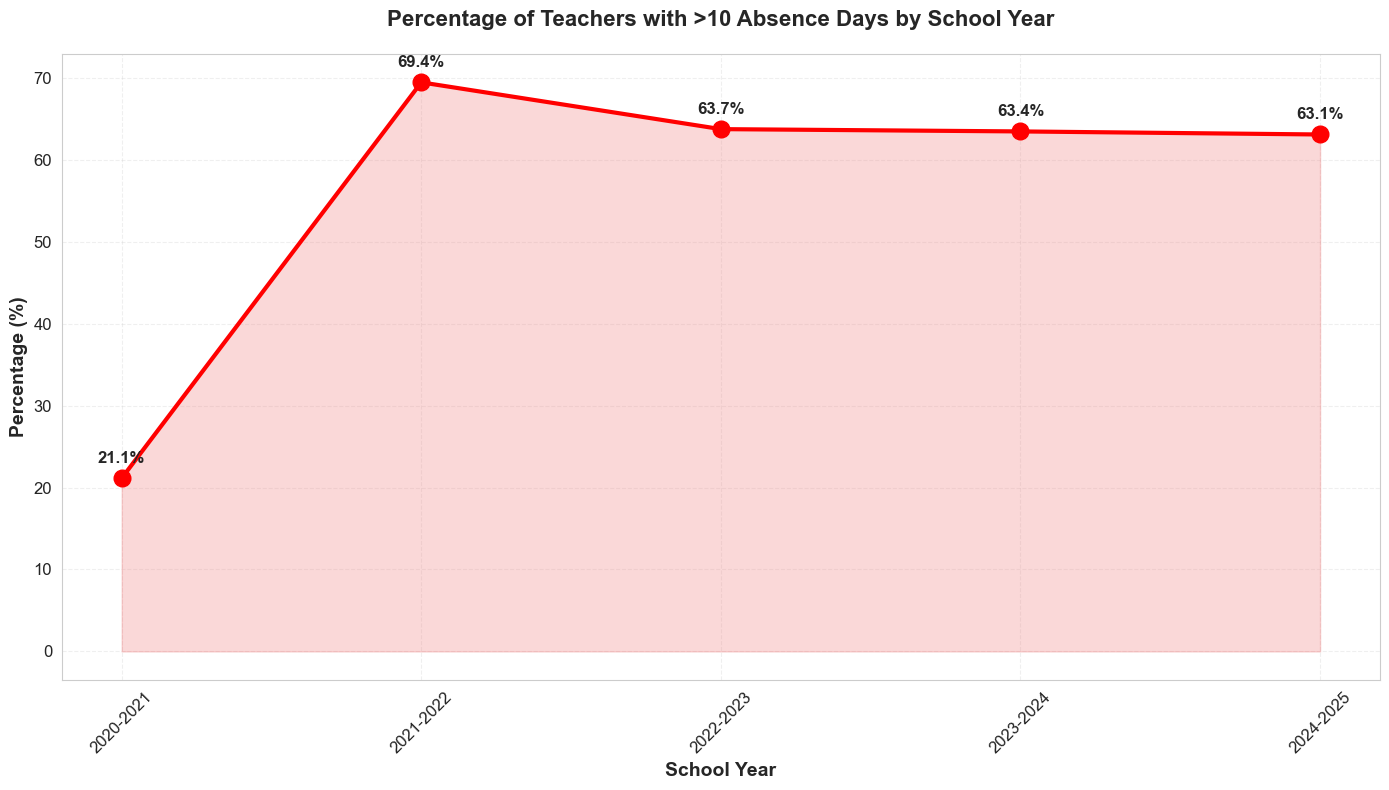

In [9]:
# Percentage of Teachers with >10 Absence Days by School Year
threshold = 10
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
pct_teachers = [data['pct_teachers'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.plot(years, pct_teachers, marker='o', linewidth=3, markersize=12, color='red')
plt.fill_between(years, pct_teachers, alpha=0.3, color='lightcoral')
plt.title(f'Percentage of Teachers with >10 Absence Days by School Year', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
for i, v in enumerate(pct_teachers):
    plt.text(i, v + 1.5, f'{v:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()



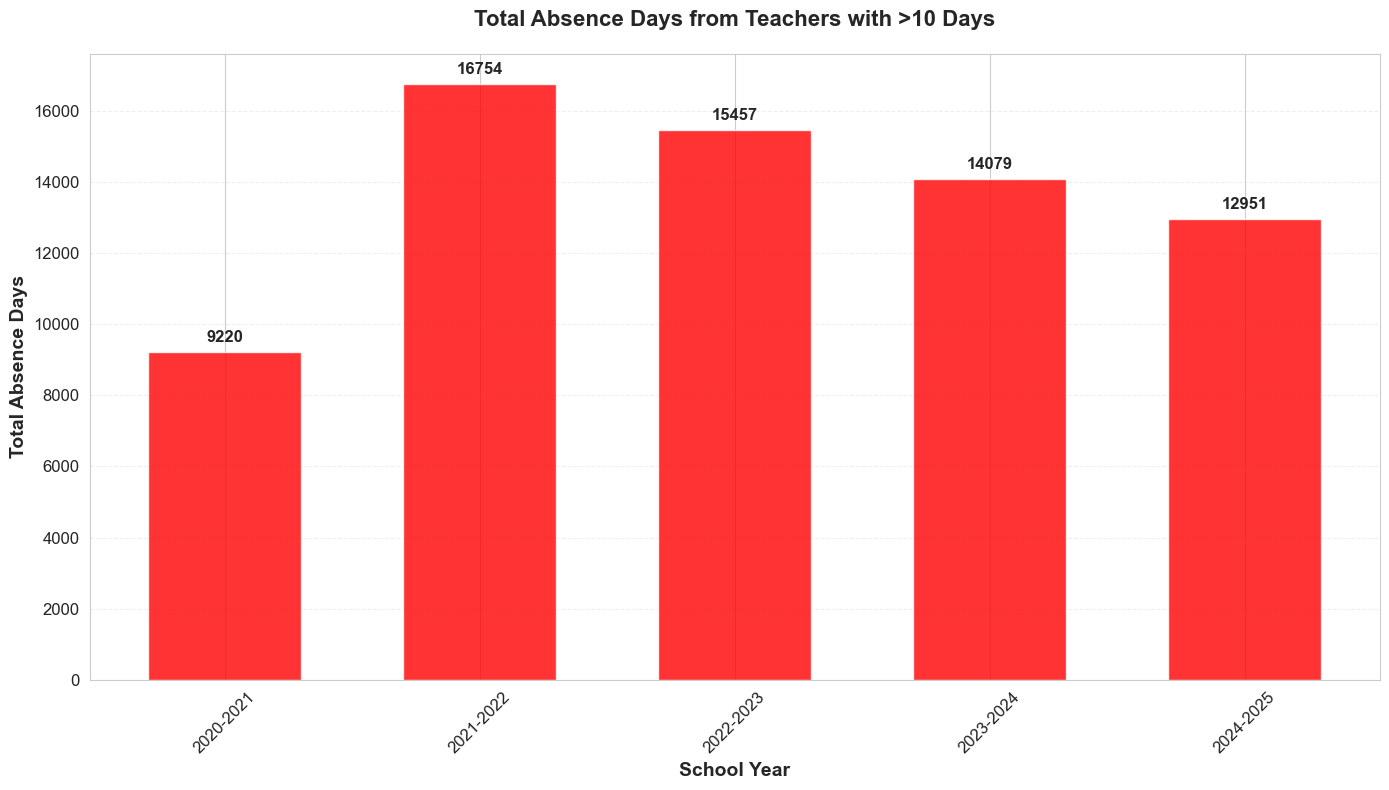

In [10]:
# Total Absence Days from Teachers with >10 Days
threshold = 10
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_days = [data['total_days_above'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.bar(years, total_days, color='red', width=0.6, alpha=0.8)
plt.title(f'Total Absence Days from Teachers with >10 Days', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Total Absence Days', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(total_days):
    plt.text(i, v + 200, f'{int(v)}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()



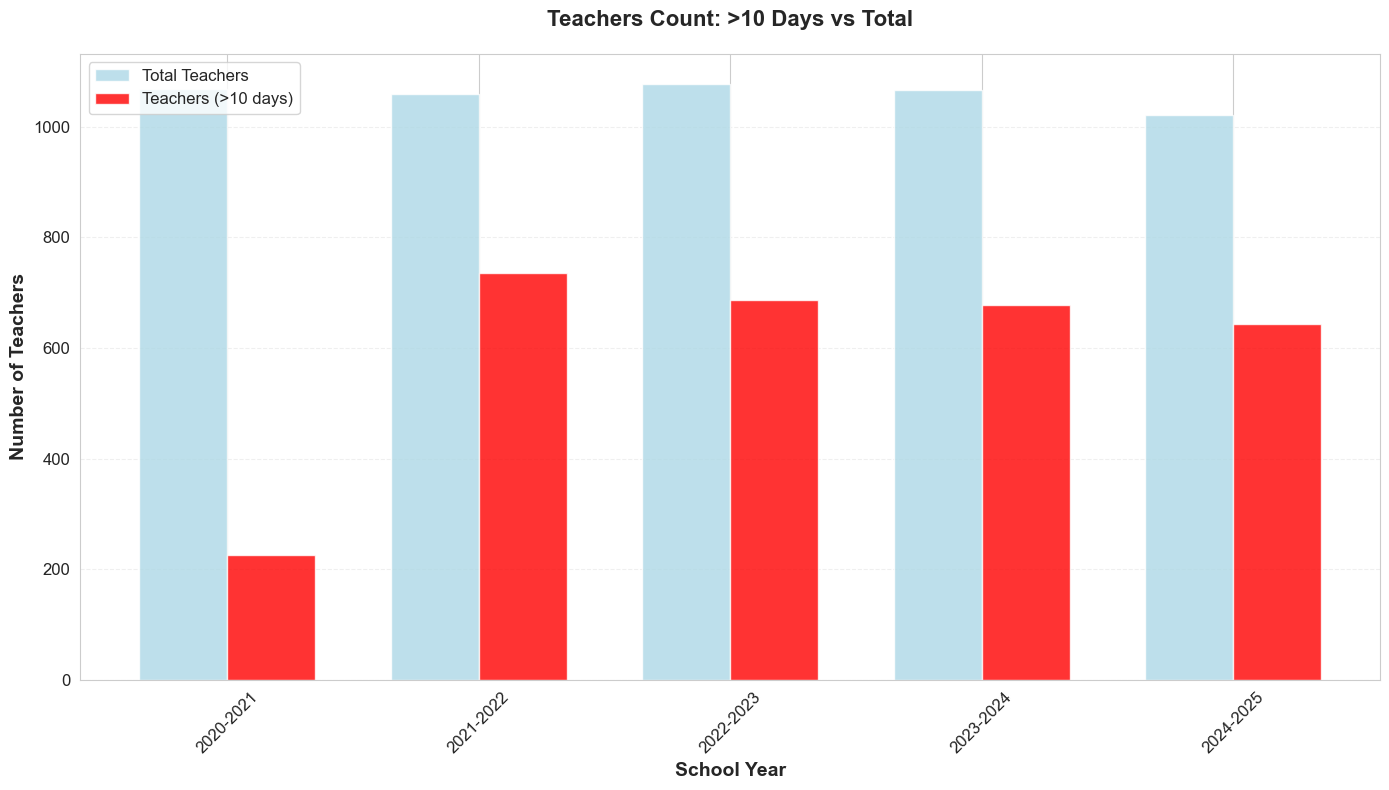

In [11]:
# Teachers Count: >10 Days vs Total
threshold = 10
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_teachers = [data['total_teachers'].get(year, 0) for year in years]
teachers_above = [data['teachers_above'].get(year, 0) for year in years]

x = np.arange(len(years))
width = 0.35

plt.figure(figsize=(14, 8))
plt.bar(x - width/2, total_teachers, width, label='Total Teachers', color='lightblue', alpha=0.8)
plt.bar(x + width/2, teachers_above, width, label=f'Teachers (>10 days)', color='red', alpha=0.8)
plt.title(f'Teachers Count: >10 Days vs Total', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Number of Teachers', fontsize=14, fontweight='bold')
plt.xticks(x, years, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



In [34]:
# ============================================================================
# ABCover Profitability Analysis
# Goal: Find the right combination of waiting period and payment rate to ESS
# that results in profitable coverage while only charging schools 10% more
# ============================================================================

# Constants
ABCOVER_RATE_TO_SCHOOL = 132.30  # Rate ABCover charges to Toms River school per day
FILL_RATE = 0.90  # ESS typically fills 90% of absences
PREMIUM_INCREASE = 0.10  # ABCover charges school 10% more than ESS rate

# Calculate ESS rate (back-calculate: if ABCover charges 10% more, then ESS rate = ABCover rate / 1.10)
CURRENT_ESS_RATE = ABCOVER_RATE_TO_SCHOOL / (1 + PREMIUM_INCREASE)  # ESS's current rate
PREMIUM_PER_DAY = ABCOVER_RATE_TO_SCHOOL - CURRENT_ESS_RATE  # ABCover's revenue per filled absence

print("="*80)
print("ABCOVER PRICING STRUCTURE - TOMS RIVER")
print("="*80)
print(f"Current ESS Rate (to school): ${CURRENT_ESS_RATE:.2f}/day")
print(f"ABCover Rate to School (10% increase): ${ABCOVER_RATE_TO_SCHOOL:.2f}/day")
print(f"Premium per filled absence: ${PREMIUM_PER_DAY:.2f}/day")
print(f"Total premium on all filled absences = ABCover's Annual Revenue")
print()

# Calculate total absences and filled absences (5-year average)
total_absences_by_year = df.groupby('School Year').size()
avg_absences_per_year = total_absences_by_year.mean()
filled_absences_per_year = avg_absences_per_year * FILL_RATE

print("="*80)
print("ANNUAL ABSENCE STATISTICS (5-Year Average)")
print("="*80)
print(f"Total Absences per Year: {avg_absences_per_year:,.0f}")
print(f"Filled Absences per Year (90% fill rate): {filled_absences_per_year:,.0f}")
print()

# Calculate ABCover's annual revenue (10% premium on ALL filled absences)
# Revenue = Premium per day × ALL Filled Absences (FIXED - does not change with threshold or payment rate)
annual_revenue = filled_absences_per_year * PREMIUM_PER_DAY
print(f"ABCover Annual Revenue (Premium on ALL filled absences): ${annual_revenue:,.2f}")
print(f"  (Premium: ${PREMIUM_PER_DAY:.2f}/day × {filled_absences_per_year:,.0f} filled absences)")
print(f"  This revenue is FIXED - school pays premium on all absences regardless of threshold")
print()

# Calculate ABCover's base rate to ESS (10% less than what ABCover charges school)
ABCOVER_RATE_TO_ESS_BASE = ABCOVER_RATE_TO_SCHOOL * (1 - 0.10)  # 10% less
print(f"ABCover Rate to ESS (10% less than school rate): ${ABCOVER_RATE_TO_ESS_BASE:.2f}/day")
print(f"  (ABCover charges school: ${ABCOVER_RATE_TO_SCHOOL:.2f}/day)")
print(f"  (ABCover pays ESS: ${ABCOVER_RATE_TO_ESS_BASE:.2f}/day)")
print()

# Test all thresholds from 10 to 80 (multiples of 5) - MUST include 25, 35, 45, 50, 55, 60, 65, 70, 75
thresholds_to_test = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

# School-specific rate to highlight (rate ABCover charges school)
SCHOOL_RATE = ABCOVER_RATE_TO_SCHOOL  # $132.30 for Toms River
# Calculate the payment rate that would result in this school rate
# If rate_charged_to_school = payment_rate * 1.10, then payment_rate = school_rate / 1.10
PAYMENT_RATE_FOR_SCHOOL_RATE = SCHOOL_RATE / 1.10

# Test different payment rates to ESS (what ABCover pays ESS for reimbursable days)
# MUST include payment rate that results in school rate ($132.30 charged to school = $120.27 paid to ESS)
# This ensures Rate Charged to School = $132.30 appears in every waiting period
# Also include various other rates
payment_rates_to_test = [80, 90, 100, 110, 120, 130, ABCOVER_RATE_TO_ESS_BASE, 140, 150, PAYMENT_RATE_FOR_SCHOOL_RATE]
# Ensure PAYMENT_RATE_FOR_SCHOOL_RATE is included (don't round it out)
payment_rates_to_test = sorted(list(set([round(rate, 2) for rate in payment_rates_to_test])))  # Remove duplicates and sort
# Verify school rate payment is included
if PAYMENT_RATE_FOR_SCHOOL_RATE not in payment_rates_to_test:
    payment_rates_to_test.append(round(PAYMENT_RATE_FOR_SCHOOL_RATE, 2))
    payment_rates_to_test = sorted(list(set(payment_rates_to_test)))

# Get reimbursable days from summary tables (5-year average)
results_matrix = []

for threshold in thresholds_to_test:
    if threshold in summary_tables:
        # Get 5-year average reimbursable days
        avg_row = summary_tables[threshold][summary_tables[threshold]['School Year'] == '5-Year Avg']
        if len(avg_row) > 0:
            reimbursable_days = avg_row['Reimbursable Days'].values[0]
            
            # Apply 90% fill rate to reimbursable days
            filled_reimbursable_days = reimbursable_days * FILL_RATE
            
            for payment_rate in payment_rates_to_test:
                # Revenue is FIXED (premium on ALL filled absences, not just reimbursable days)
                # School pays ABCover premium on all absences regardless of threshold
                # annual_revenue is already calculated above (fixed for all scenarios)
                
                # Rate Charged to School = Rate Paid to ESS × 1.10 (10% more - DYNAMIC)
                rate_charged_to_school = payment_rate * 1.10
                
                # Calculate ABCover's cost (what they pay to ESS for reimbursable days only)
                # Cost = Rate Paid to ESS × Filled Reimbursable Days (only days above threshold)
                abcover_cost = filled_reimbursable_days * payment_rate
                
                # Calculate profit/loss
                # Revenue (fixed) - Cost (varies by threshold and payment rate)
                profit_loss = annual_revenue - abcover_cost
                
                # Calculate profit margin
                profit_margin_pct = (profit_loss / annual_revenue * 100) if annual_revenue > 0 else 0
                
                # Check if Rate Charged to School matches the school-specific rate (to highlight later)
                is_school_rate = (abs(rate_charged_to_school - SCHOOL_RATE) < 0.01)
                
                results_matrix.append({
                    'Waiting Period': f'>{threshold} days',
                    'Reimbursable Days': round(reimbursable_days, 1),
                    'Filled Reimbursable Days': round(filled_reimbursable_days, 1),
                    'Rate Charged to School': f'${rate_charged_to_school:.2f}',
                    'Rate Paid to ESS': f'${payment_rate:.2f}',
                    'Total Cost to ABCover': f'${abcover_cost:,.2f}',
                    'ABCover Annual Revenue': f'${annual_revenue:,.2f}',
                    'Net Profit/Loss': f'${profit_loss:,.2f}',
                    'Profit Margin %': f'{profit_margin_pct:.1f}%',
                    'Is_School_Rate': is_school_rate  # Flag for highlighting
                })

# Create results DataFrame
results_df = pd.DataFrame(results_matrix)

# Display results with color coding
print("\n" + "="*140)
print("PROFITABILITY MATRIX - All Scenarios")
print("="*140)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Convert Net Profit/Loss to numeric for styling
results_df['Profit_Loss_Numeric'] = results_df['Net Profit/Loss'].str.replace('$', '').str.replace(',', '').astype(float)

# Create styled DataFrame with color coding
def color_profit_loss(val):
    """Color profit green, loss red"""
    try:
        if isinstance(val, str):
            # Remove $ and commas, handle negative sign
            numeric_val = float(val.replace('$', '').replace(',', '').strip())
        else:
            numeric_val = float(val)
        if numeric_val > 0:
            return 'background-color: #90EE90'  # Light green
        elif numeric_val < 0:
            return 'background-color: #FFB6C1'  # Light red
        else:
            return 'background-color: #FFFFFF'  # White
    except:
        return 'background-color: #FFFFFF'  # Default white if parsing fails

def highlight_school_rate(row):
    """Highlight rows where Rate Paid to ESS equals school rate"""
    if row.get('Is_School_Rate', False):
        return ['background-color: #FFD700'] * len(row)  # Gold highlight for school rate
    return [''] * len(row)

# Apply styling to Net Profit/Loss column (exclude helper columns from display)
display_df = results_df.drop(columns=['Profit_Loss_Numeric', 'Is_School_Rate'], errors='ignore')
styled_df = display_df.style.applymap(color_profit_loss, subset=['Net Profit/Loss']).apply(highlight_school_rate, axis=1)
from IPython.display import display
display(styled_df)
print()

# Highlight profitable scenarios
profitable_scenarios = results_df[results_df['Profit_Loss_Numeric'] > 0].copy()
print("\n" + "="*140)
print("PROFITABLE SCENARIOS (Profit > $0)")
print("="*140)
if len(profitable_scenarios) > 0:
    # Apply green color to profitable scenarios (exclude helper column from display)
    display_profitable = profitable_scenarios.drop(columns=['Profit_Loss_Numeric'], errors='ignore')
    styled_profitable = display_profitable.style.applymap(lambda x: 'background-color: #90EE90', subset=['Net Profit/Loss'])
    display(styled_profitable)
    print(f"\nTotal Profitable Scenarios: {len(profitable_scenarios)}")
else:
    print("No profitable scenarios found with current parameters.")
print()

# Find optimal scenarios (highest profit)
print("="*140)
print("TOP 15 MOST PROFITABLE SCENARIOS")
print("="*140)

# Get top 15 by profit, but also include school rate scenarios even if not in top 15
top_scenarios = results_df.nlargest(15, 'Profit_Loss_Numeric').copy()

# Also include school rate scenarios if not already in top 15
school_rate_scenarios = results_df[results_df['Is_School_Rate'] == True]
for idx, row in school_rate_scenarios.iterrows():
    if idx not in top_scenarios.index:
        top_scenarios = pd.concat([top_scenarios, pd.DataFrame([row])], ignore_index=True)

# Sort by profit again and take top 15
top_scenarios = top_scenarios.nlargest(15, 'Profit_Loss_Numeric')[['Waiting Period', 'Rate Charged to School', 'Rate Paid to ESS', 
                                                                 'Filled Reimbursable Days',
                                                                 'Total Cost to ABCover', 'ABCover Annual Revenue', 
                                                                 'Net Profit/Loss', 'Profit Margin %', 'Is_School_Rate']].copy()

# Apply styling
def style_top_scenarios(row):
    styles = [''] * len(row)
    profit_loss_idx = list(row.index).index('Net Profit/Loss')
    school_rate_idx = list(row.index).index('Is_School_Rate')
    
    # Color profit/loss
    try:
        profit_val = float(str(row['Net Profit/Loss']).replace('$', '').replace(',', '').strip())
        if profit_val > 0:
            styles[profit_loss_idx] = 'background-color: #90EE90'  # Green
        elif profit_val < 0:
            styles[profit_loss_idx] = 'background-color: #FFB6C1'  # Red
    except:
        pass
    
    # Highlight school rate rows
    if row.get('Is_School_Rate', False):
        styles = ['background-color: #FFD700'] * len(row)  # Gold for entire row
        # But keep profit/loss color
        try:
            profit_val = float(str(row['Net Profit/Loss']).replace('$', '').replace(',', '').strip())
            if profit_val > 0:
                styles[profit_loss_idx] = 'background-color: #90EE90'  # Green
            elif profit_val < 0:
                styles[profit_loss_idx] = 'background-color: #FFB6C1'  # Red
        except:
            pass
    
    return styles

styled_top = top_scenarios.drop(columns=['Is_School_Rate'], errors='ignore').style.apply(style_top_scenarios, axis=1)
display(styled_top)
print()

# Summary by waiting period (best payment rate for each)
print("="*140)
print("BEST PAYMENT RATE FOR EACH WAITING PERIOD (Most Profitable)")
print("="*140)
best_by_threshold = []
for threshold in thresholds_to_test:
    threshold_data = results_df[results_df['Waiting Period'] == f'>{threshold} days']
    if len(threshold_data) > 0:
        best_scenario = threshold_data.nlargest(1, 'Profit_Loss_Numeric')
        if len(best_scenario) > 0 and best_scenario['Profit_Loss_Numeric'].values[0] > 0:
            best_by_threshold.append(best_scenario[['Waiting Period', 'Rate Charged to School', 'Rate Paid to ESS', 
                                                     'Filled Reimbursable Days',
                                                     'Total Cost to ABCover', 'Net Profit/Loss', 'Profit Margin %']].iloc[0])

if len(best_by_threshold) > 0:
    best_df = pd.DataFrame(best_by_threshold)
    # Apply green color to all (they're all profitable)
    styled_best = best_df.style.applymap(lambda x: 'background-color: #90EE90', subset=['Net Profit/Loss'])
    display(styled_best)
else:
    print("No profitable scenarios found.")
print()

ABCOVER PRICING STRUCTURE - TOMS RIVER
Current ESS Rate (to school): $120.27/day
ABCover Rate to School (10% increase): $132.30/day
Premium per filled absence: $12.03/day
Total premium on all filled absences = ABCover's Annual Revenue

ANNUAL ABSENCE STATISTICS (5-Year Average)
Total Absences per Year: 19,824
Filled Absences per Year (90% fill rate): 17,842

ABCover Annual Revenue (Premium on ALL filled absences): $214,585.79
  (Premium: $12.03/day × 17,842 filled absences)
  This revenue is FIXED - school pays premium on all absences regardless of threshold

ABCover Rate to ESS (10% less than school rate): $119.07/day
  (ABCover charges school: $132.30/day)
  (ABCover pays ESS: $119.07/day)


PROFITABILITY MATRIX - All Scenarios


/var/folders/gq/wkkqjm_d00ggs329s5bxsx300000gn/T/ipykernel_9564/724498218.py:161: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = display_df.style.applymap(color_profit_loss, subset=['Net Profit/Loss']).apply(highlight_school_rate, axis=1)


,Waiting Period,Reimbursable Days,Filled Reimbursable Days,Rate Charged to School,Rate Paid to ESS,Total Cost to ABCover,ABCover Annual Revenue,Net Profit/Loss,Profit Margin %
0,>10 days,7752.600000,6977.300000,$88.00,$80.00,"$558,187.20","$214,585.79","$-343,601.41",-160.1%
1,>10 days,7752.600000,6977.300000,$99.00,$90.00,"$627,960.60","$214,585.79","$-413,374.81",-192.6%
2,>10 days,7752.600000,6977.300000,$110.00,$100.00,"$697,734.00","$214,585.79","$-483,148.21",-225.2%
3,>10 days,7752.600000,6977.300000,$121.00,$110.00,"$767,507.40","$214,585.79","$-552,921.61",-257.7%
4,>10 days,7752.600000,6977.300000,$130.98,$119.07,"$830,791.87","$214,585.79","$-616,206.08",-287.2%
5,>10 days,7752.600000,6977.300000,$132.00,$120.00,"$837,280.80","$214,585.79","$-622,695.01",-290.2%
6,>10 days,7752.600000,6977.300000,$132.30,$120.27,"$839,164.68","$214,585.79","$-624,578.89",-291.1%
7,>10 days,7752.600000,6977.300000,$143.00,$130.00,"$907,054.20","$214,585.79","$-692,468.41",-322.7%
8,>10 days,7752.600000,6977.300000,$154.00,$140.00,"$976,827.60","$214,585.79","$-762,241.81",-355.2%
9,>10 days,7752.600000,6977.300000,$165.00,$150.00,"$1,046,601.00","$214,585.79","$-832,015.21",-387.7%




PROFITABLE SCENARIOS (Profit > $0)


/var/folders/gq/wkkqjm_d00ggs329s5bxsx300000gn/T/ipykernel_9564/724498218.py:174: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_profitable = display_profitable.style.applymap(lambda x: 'background-color: #90EE90', subset=['Net Profit/Loss'])


,Waiting Period,Reimbursable Days,Filled Reimbursable Days,Rate Charged to School,Rate Paid to ESS,Total Cost to ABCover,ABCover Annual Revenue,Net Profit/Loss,Profit Margin %,Is_School_Rate
40,>40 days,2419.400000,2177.500000,$88.00,$80.00,"$174,196.80","$214,585.79","$40,388.99",18.8%,False
41,>40 days,2419.400000,2177.500000,$99.00,$90.00,"$195,971.40","$214,585.79","$18,614.39",8.7%,False
50,>50 days,1880.500000,1692.400000,$88.00,$80.00,"$135,396.00","$214,585.79","$79,189.79",36.9%,False
51,>50 days,1880.500000,1692.400000,$99.00,$90.00,"$152,320.50","$214,585.79","$62,265.29",29.0%,False
52,>50 days,1880.500000,1692.400000,$110.00,$100.00,"$169,245.00","$214,585.79","$45,340.79",21.1%,False
53,>50 days,1880.500000,1692.400000,$121.00,$110.00,"$186,169.50","$214,585.79","$28,416.29",13.2%,False
54,>50 days,1880.500000,1692.400000,$130.98,$119.07,"$201,520.02","$214,585.79","$13,065.77",6.1%,False
55,>50 days,1880.500000,1692.400000,$132.00,$120.00,"$203,094.00","$214,585.79","$11,491.79",5.4%,False
56,>50 days,1880.500000,1692.400000,$132.30,$120.27,"$203,550.96","$214,585.79","$11,034.83",5.1%,True
60,>60 days,1476.100000,1328.500000,$88.00,$80.00,"$106,279.20","$214,585.79","$108,306.59",50.5%,False



Total Profitable Scenarios: 29

TOP 15 MOST PROFITABLE SCENARIOS


ValueError: 'Is_School_Rate' is not in list


BEST PAYMENT RATE FOR EACH WAITING PERIOD (Most Profitable)


/var/folders/gq/wkkqjm_d00ggs329s5bxsx300000gn/T/ipykernel_9564/724498218.py:253: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_best = best_df.style.applymap(lambda x: 'background-color: #90EE90', subset=['Net Profit/Loss'])


,Waiting Period,Rate Charged to School,Rate Paid to ESS,Filled Reimbursable Days,Total Cost to ABCover,Net Profit/Loss,Profit Margin %
40,>40 days,$88.00,$80.00,2177.500000,"$174,196.80","$40,388.99",18.8%
50,>50 days,$88.00,$80.00,1692.400000,"$135,396.00","$79,189.79",36.9%
60,>60 days,$88.00,$80.00,1328.500000,"$106,279.20","$108,306.59",50.5%
70,>80 days,$88.00,$80.00,823.100000,"$65,851.20","$148,734.59",69.3%


In [ ]:
# Summary tables with deductible days, reimbursable days, and replacement costs
summary_tables = {}

for threshold in thresholds:
    data = results[threshold]
    years = sorted(teacher_absence_days['School Year'].unique())
    
    summary_data = []
    for year in years:
        num_staff = int(data['teachers_above'].get(year, 0))
        total_days = data['total_days_above'].get(year, 0)
        deductible_days = threshold * num_staff  # Insurance coverage starts from day (threshold+1): >10 from day 11, >15 from day 16, >20 from day 21, >30 from day 31, >40 from day 41
        reimbursable_days = total_days - deductible_days
        replacement_cost = reimbursable_days * SUBSTITUTE_COST_PER_DAY
        total_teachers = int(data['total_teachers'].get(year, 0))
        pct_teachers = data['pct_teachers'].get(year, 0)
        
        summary_data.append({
            'School Year': year,
            '# of Staff (>{} days)'.format(threshold): num_staff,
            'Total Days Taken': round(total_days, 1),
            'Deductible Days': -deductible_days,
            'Reimbursable Days': round(reimbursable_days, 1),
            'Replacement Cost': round(replacement_cost, 1),
            '% of Teachers': round(pct_teachers, 1)
        })
    
    # Calculate 5-year average
    avg_num_staff = np.mean([d['# of Staff (>{} days)'.format(threshold)] for d in summary_data])
    avg_total_days = np.mean([d['Total Days Taken'] for d in summary_data])
    avg_deductible = np.mean([abs(d['Deductible Days']) for d in summary_data])
    avg_reimbursable = np.mean([d['Reimbursable Days'] for d in summary_data])
    avg_cost = np.mean([d['Replacement Cost'] for d in summary_data])
    avg_pct = np.mean([d['% of Teachers'] for d in summary_data])
    
    summary_data.append({
        'School Year': '5-Year Avg',
        '# of Staff (>{} days)'.format(threshold): round(avg_num_staff, 1),
        'Total Days Taken': round(avg_total_days, 1),
        'Deductible Days': -round(avg_deductible, 1),
        'Reimbursable Days': round(avg_reimbursable, 1),
        'Replacement Cost': round(avg_cost, 1),
        '% of Teachers': round(avg_pct, 1)
    })
    
    summary_df = pd.DataFrame(summary_data)
    summary_tables[threshold] = summary_df
    
    print(f"\n{'='*80}")
    print(f"GREATER THAN {threshold} DAYS ABSENCE SUMMARY (Replacement Cost @ ${SUBSTITUTE_COST_PER_DAY}/day)")
    print(f"{'='*80}")
    print(summary_df.to_string(index=False))
    print()




GREATER THAN 10 DAYS ABSENCE SUMMARY (Replacement Cost @ $132.3/day)
School Year  # of Staff (>10 days)  Total Days Taken  Deductible Days  Reimbursable Days  Replacement Cost  % of Teachers
  2020-2021                  226.0            9220.5          -2260.0             6960.5          920876.8           21.1
  2021-2022                  736.0           16754.7          -7360.0             9394.7         1242924.7           69.4
  2022-2023                  687.0           15457.7          -6870.0             8587.7         1136152.7           63.7
  2023-2024                  677.0           14079.0          -6770.0             7309.0          966980.7           63.4
  2024-2025                  644.0           12951.3          -6440.0             6511.3          861450.9           63.1
 5-Year Avg                  594.0           13692.6          -5940.0             7752.6         1025677.2           56.1


GREATER THAN 15 DAYS ABSENCE SUMMARY (Replacement Cost @ $132.3/day)
Schoo

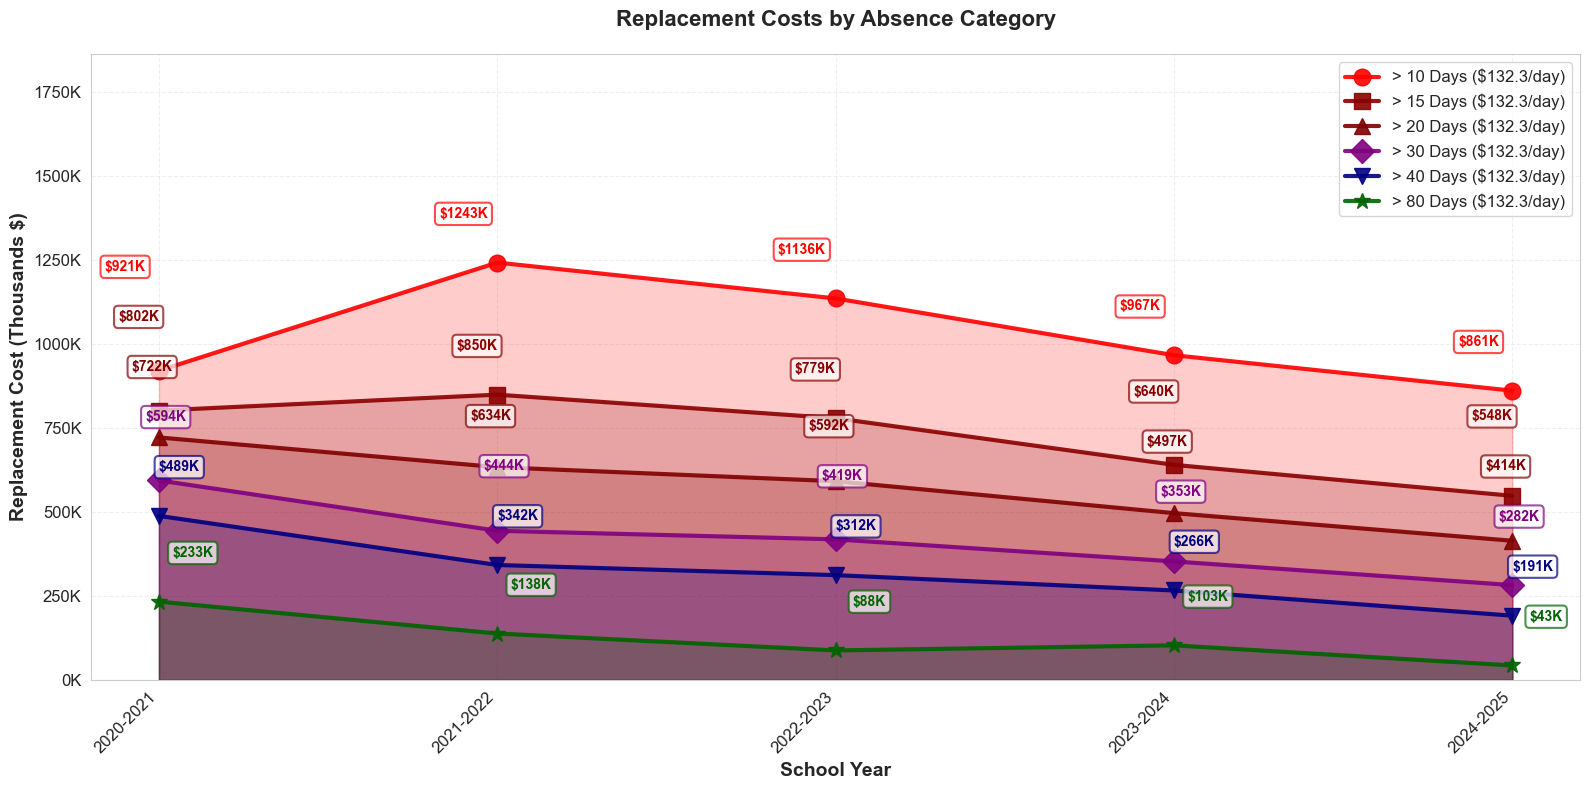

In [ ]:
# Replacement Costs by Absence Category
years = sorted(teacher_absence_days['School Year'].unique())

# Prepare data for replacement costs
replacement_costs = {}
for threshold in thresholds:
    costs = []
    for year in years:
        summary = summary_tables[threshold]
        year_data = summary[summary['School Year'] == year]
        if len(year_data) > 0:
            costs.append(year_data['Replacement Cost'].values[0])
        else:
            costs.append(0)
    replacement_costs[threshold] = costs

plt.figure(figsize=(16, 8))
plt.plot(years, replacement_costs[10], marker='o', linewidth=3, markersize=12, 
         label='> 10 Days ($132.3/day)', color='red', alpha=0.9)
plt.fill_between(years, replacement_costs[10], alpha=0.2, color='red')
plt.plot(years, replacement_costs[15], marker='s', linewidth=3, markersize=12, 
         label='> 15 Days ($132.3/day)', color='darkred', alpha=0.9)
plt.fill_between(years, replacement_costs[15], alpha=0.2, color='darkred')
plt.plot(years, replacement_costs[20], marker='^', linewidth=3, markersize=12, 
         label='> 20 Days ($132.3/day)', color='maroon', alpha=0.9)
plt.fill_between(years, replacement_costs[20], alpha=0.2, color='maroon')
plt.plot(years, replacement_costs[30], marker='D', linewidth=3, markersize=12, 
         label='> 30 Days ($132.3/day)', color='purple', alpha=0.9)
plt.fill_between(years, replacement_costs[30], alpha=0.2, color='purple')
plt.plot(years, replacement_costs[40], marker='v', linewidth=3, markersize=12, 
         label='> 40 Days ($132.3/day)', color='navy', alpha=0.9)
plt.fill_between(years, replacement_costs[40], alpha=0.2, color='navy')
plt.plot(years, replacement_costs[80], marker='*', linewidth=3, markersize=12, 
         label='> 80 Days ($132.3/day)', color='darkgreen', alpha=0.9)
plt.fill_between(years, replacement_costs[80], alpha=0.2, color='darkgreen')

# Set y-axis limit to give more room for labels
max_cost = max(max(replacement_costs[10]), max(replacement_costs[15]), max(replacement_costs[20]),
               max(replacement_costs[30]), max(replacement_costs[40]), max(replacement_costs[80]))
plt.ylim(0, max_cost * 1.50)  # Add 50% more space at top for clear label positioning

# Add cost labels at each data point - position with much better clearance from markers
for i, year in enumerate(years):
    # Get all values for this year and sort them by value (lowest to highest)
    values_at_year = [(threshold, replacement_costs[threshold][i]) for threshold in [10, 15, 20, 30, 40, 80]]
    values_at_year.sort(key=lambda x: x[1])  # Sort by actual value
    
    # Calculate spacing - use larger values for better readability
    min_spacing = max_cost * 0.12  # Minimum 12% of max cost between labels (increased from 8%)
    base_clearance = max_cost * 0.10  # 10% of max cost as minimum clearance above marker (increased from 6%)
    
    # Position labels from bottom to top with generous spacing
    label_positions = {}
    prev_y_pos = None
    
    for rank, (threshold, value) in enumerate(values_at_year):
        # Calculate desired position well above the marker
        desired_pos = value + base_clearance
        
        # If this isn't the first label, ensure it's well spaced above the previous one
        if prev_y_pos is not None:
            # Make sure there's enough spacing between labels
            if desired_pos < prev_y_pos + min_spacing:
                y_pos = prev_y_pos + min_spacing
            else:
                y_pos = desired_pos
        else:
            # First (lowest) label - ensure good clearance from marker
            y_pos = desired_pos
        
        label_positions[threshold] = y_pos
        prev_y_pos = y_pos
    
    # Plot labels with better positioning - slightly offset horizontally to avoid marker overlap
    color_map = {10: 'red', 15: 'darkred', 20: 'maroon', 30: 'purple', 40: 'navy', 80: 'darkgreen'}
    # Horizontal offset pattern to spread labels left/right slightly
    h_offsets = {10: -0.10, 15: -0.06, 20: -0.02, 30: 0.02, 40: 0.06, 80: 0.10}
    
    for threshold in [10, 15, 20, 30, 40, 80]:
        value = replacement_costs[threshold][i]
        y_pos = label_positions[threshold]
        color = color_map[threshold]
        # Add horizontal offset to avoid direct overlap with markers
        x_pos = i + h_offsets[threshold]
        plt.text(x_pos, y_pos, f'${value/1000:.0f}K', 
                 ha='center', va='bottom', fontsize=10, fontweight='bold', color=color,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color, alpha=0.7, linewidth=1.5))
plt.title('Replacement Costs by Absence Category', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Replacement Cost (Thousands $)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')  # Align rotated labels to the right
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
plt.tight_layout()
plt.show()



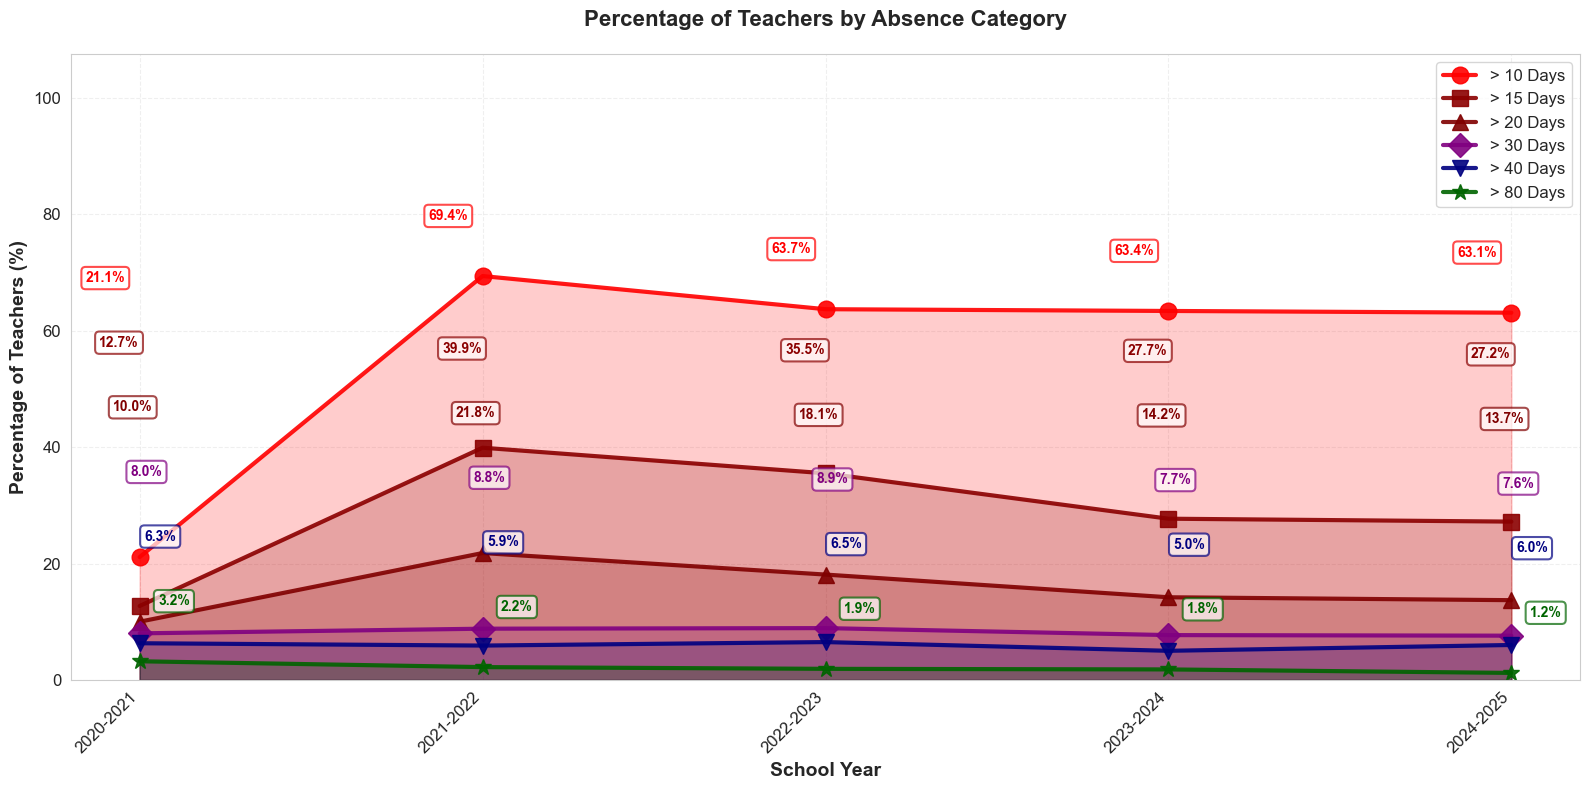

In [29]:
# Percentage of Teachers by Absence Category
years = sorted(teacher_absence_days['School Year'].unique())

# Prepare data for percentages
pct_teachers_combined = {}
for threshold in thresholds:
    pcts = []
    for year in years:
        summary = summary_tables[threshold]
        year_data = summary[summary['School Year'] == year]
        if len(year_data) > 0:
            pcts.append(year_data['% of Teachers'].values[0])
        else:
            pcts.append(0)
    pct_teachers_combined[threshold] = pcts

plt.figure(figsize=(16, 8))
plt.plot(years, pct_teachers_combined[10], marker='o', linewidth=3, markersize=12, 
         label='> 10 Days', color='red', alpha=0.9)
plt.fill_between(years, pct_teachers_combined[10], alpha=0.2, color='red')
plt.plot(years, pct_teachers_combined[15], marker='s', linewidth=3, markersize=12, 
         label='> 15 Days', color='darkred', alpha=0.9)
plt.fill_between(years, pct_teachers_combined[15], alpha=0.2, color='darkred')
plt.plot(years, pct_teachers_combined[20], marker='^', linewidth=3, markersize=12, 
         label='> 20 Days', color='maroon', alpha=0.9)
plt.fill_between(years, pct_teachers_combined[20], alpha=0.2, color='maroon')
plt.plot(years, pct_teachers_combined[30], marker='D', linewidth=3, markersize=12, 
         label='> 30 Days', color='purple', alpha=0.9)
plt.fill_between(years, pct_teachers_combined[30], alpha=0.2, color='purple')
plt.plot(years, pct_teachers_combined[40], marker='v', linewidth=3, markersize=12, 
         label='> 40 Days', color='navy', alpha=0.9)
plt.fill_between(years, pct_teachers_combined[40], alpha=0.2, color='navy')
plt.plot(years, pct_teachers_combined[80], marker='*', linewidth=3, markersize=12, 
         label='> 80 Days', color='darkgreen', alpha=0.9)
plt.fill_between(years, pct_teachers_combined[80], alpha=0.2, color='darkgreen')

# Set y-axis limit to give more room for labels
max_pct = max(max(pct_teachers_combined[10]), max(pct_teachers_combined[15]), max(pct_teachers_combined[20]),
              max(pct_teachers_combined[30]), max(pct_teachers_combined[40]), max(pct_teachers_combined[80]))
plt.ylim(0, max_pct * 1.55)  # Add 55% more space at top for clear label positioning

# Add percentage labels at each data point - position with much better clearance from markers
for i, year in enumerate(years):
    # Get all values for this year and sort them by value (lowest to highest)
    values_at_year = [(threshold, pct_teachers_combined[threshold][i]) for threshold in [10, 15, 20, 30, 40, 80]]
    values_at_year.sort(key=lambda x: x[1])  # Sort by actual value
    
    # Calculate spacing - use larger values for better readability
    min_spacing = max_pct * 0.16  # Minimum 16% of max percentage between labels (increased from 12%)
    base_clearance = max_pct * 0.12  # 12% of max percentage as minimum clearance above marker (increased from 8%)
    
    # Position labels from bottom to top with generous spacing
    label_positions = {}
    prev_y_pos = None
    
    for rank, (threshold, value) in enumerate(values_at_year):
        # Calculate desired position well above the marker
        desired_pos = value + base_clearance + 0.8
        
        # If this isn't the first label, ensure it's well spaced above the previous one
        if prev_y_pos is not None:
            # Make sure there's enough spacing between labels
            if desired_pos < prev_y_pos + min_spacing:
                y_pos = prev_y_pos + min_spacing
            else:
                y_pos = desired_pos
        else:
            # First (lowest) label - ensure good clearance from marker
            y_pos = desired_pos
        
        label_positions[threshold] = y_pos
        prev_y_pos = y_pos
    
    # Plot labels with better positioning - slightly offset horizontally to avoid marker overlap
    color_map = {10: 'red', 15: 'darkred', 20: 'maroon', 30: 'purple', 40: 'navy', 80: 'darkgreen'}
    # Horizontal offset pattern to spread labels left/right slightly
    h_offsets = {10: -0.10, 15: -0.06, 20: -0.02, 30: 0.02, 40: 0.06, 80: 0.10}
    
    for threshold in [10, 15, 20, 30, 40, 80]:
        value = pct_teachers_combined[threshold][i]
        y_pos = label_positions[threshold]
        color = color_map[threshold]
        # Add horizontal offset to avoid direct overlap with markers
        x_pos = i + h_offsets[threshold]
        plt.text(x_pos, y_pos, f'{value:.1f}%', 
                 ha='center', va='bottom', fontsize=10, fontweight='bold', color=color,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color, alpha=0.7, linewidth=1.5))
plt.title('Percentage of Teachers by Absence Category', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of Teachers (%)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')  # Align rotated labels to the right
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



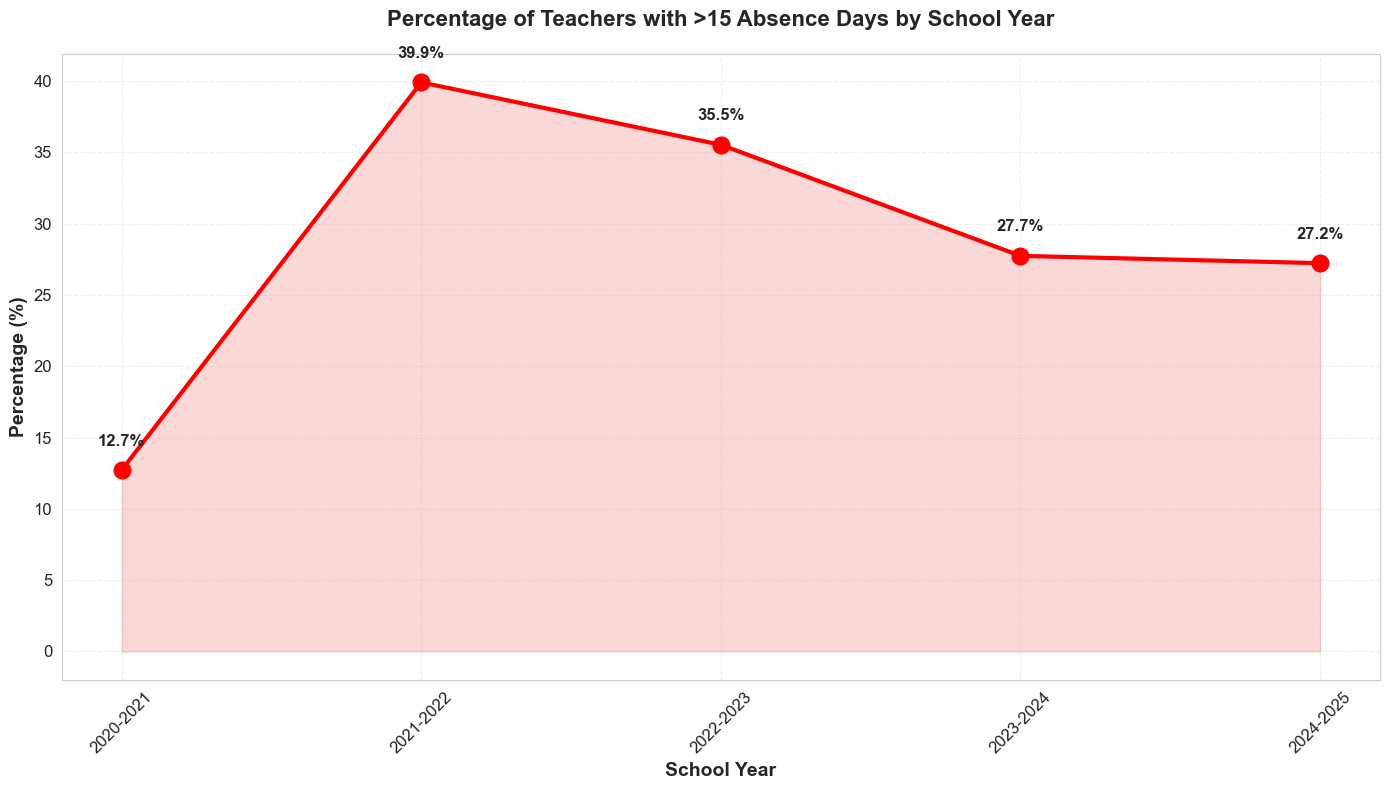

In [15]:
# Percentage of Teachers with >15 Absence Days by School Year
threshold = 15
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
pct_teachers = [data['pct_teachers'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.plot(years, pct_teachers, marker='o', linewidth=3, markersize=12, color='red')
plt.fill_between(years, pct_teachers, alpha=0.3, color='lightcoral')
plt.title(f'Percentage of Teachers with >15 Absence Days by School Year', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
for i, v in enumerate(pct_teachers):
    plt.text(i, v + 1.5, f'{v:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()



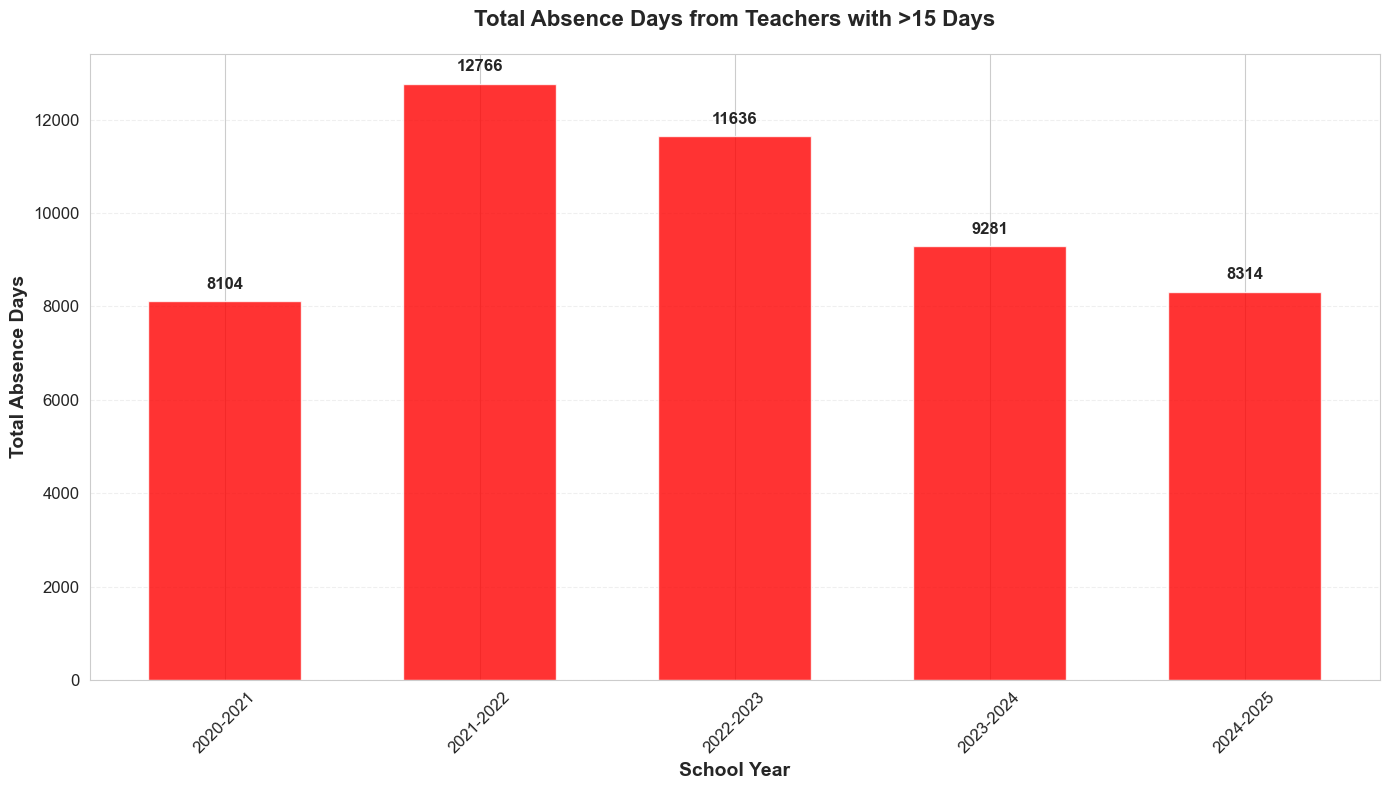

In [16]:
# Total Absence Days from Teachers with >15 Days
threshold = 15
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_days = [data['total_days_above'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.bar(years, total_days, color='red', width=0.6, alpha=0.8)
plt.title(f'Total Absence Days from Teachers with >15 Days', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Total Absence Days', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(total_days):
    plt.text(i, v + 200, f'{int(v)}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()



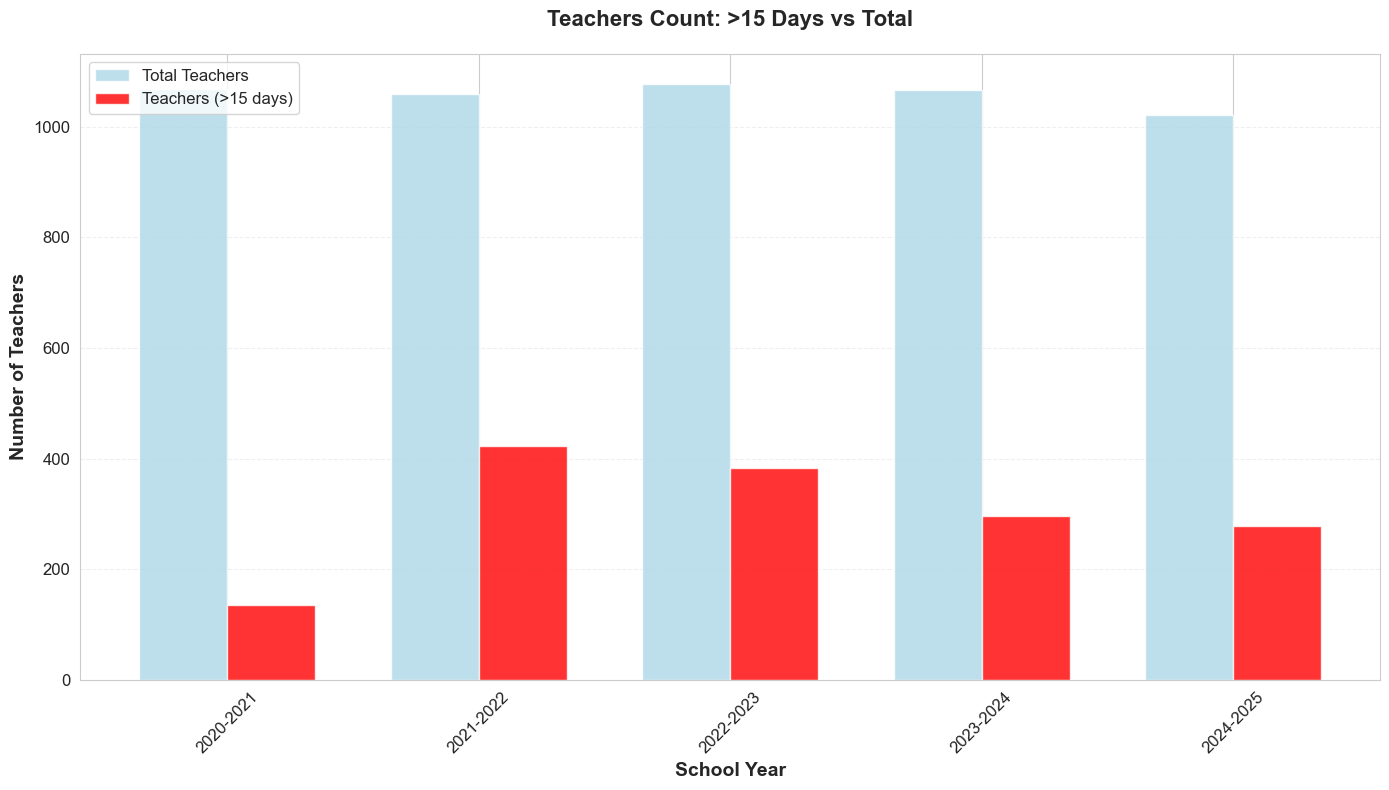

In [17]:
# Teachers Count: >15 Days vs Total
threshold = 15
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_teachers = [data['total_teachers'].get(year, 0) for year in years]
teachers_above = [data['teachers_above'].get(year, 0) for year in years]

x = np.arange(len(years))
width = 0.35

plt.figure(figsize=(14, 8))
plt.bar(x - width/2, total_teachers, width, label='Total Teachers', color='lightblue', alpha=0.8)
plt.bar(x + width/2, teachers_above, width, label=f'Teachers (>15 days)', color='red', alpha=0.8)
plt.title(f'Teachers Count: >15 Days vs Total', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Number of Teachers', fontsize=14, fontweight='bold')
plt.xticks(x, years, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



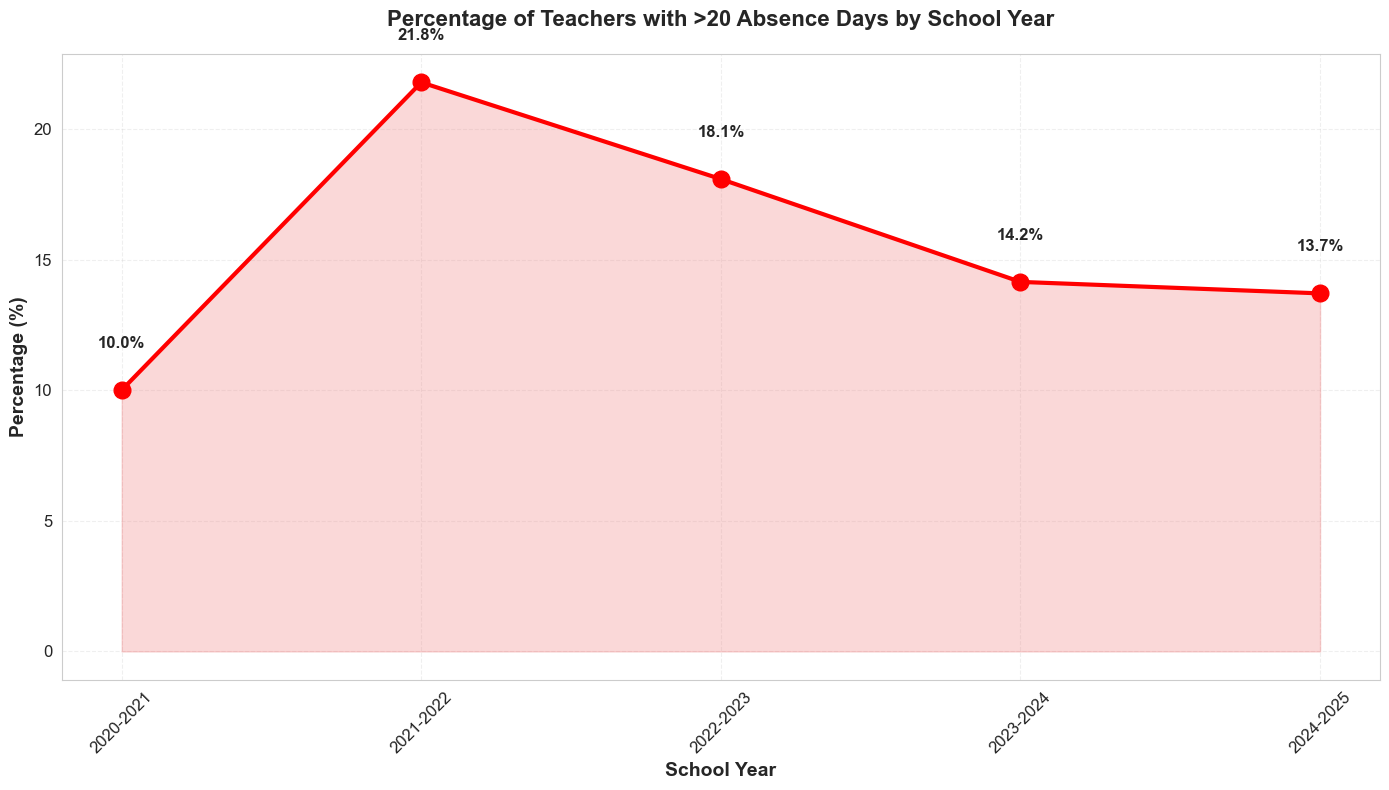

In [18]:
# Percentage of Teachers with >20 Absence Days by School Year
threshold = 20
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
pct_teachers = [data['pct_teachers'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.plot(years, pct_teachers, marker='o', linewidth=3, markersize=12, color='red')
plt.fill_between(years, pct_teachers, alpha=0.3, color='lightcoral')
plt.title(f'Percentage of Teachers with >20 Absence Days by School Year', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
for i, v in enumerate(pct_teachers):
    plt.text(i, v + 1.5, f'{v:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()



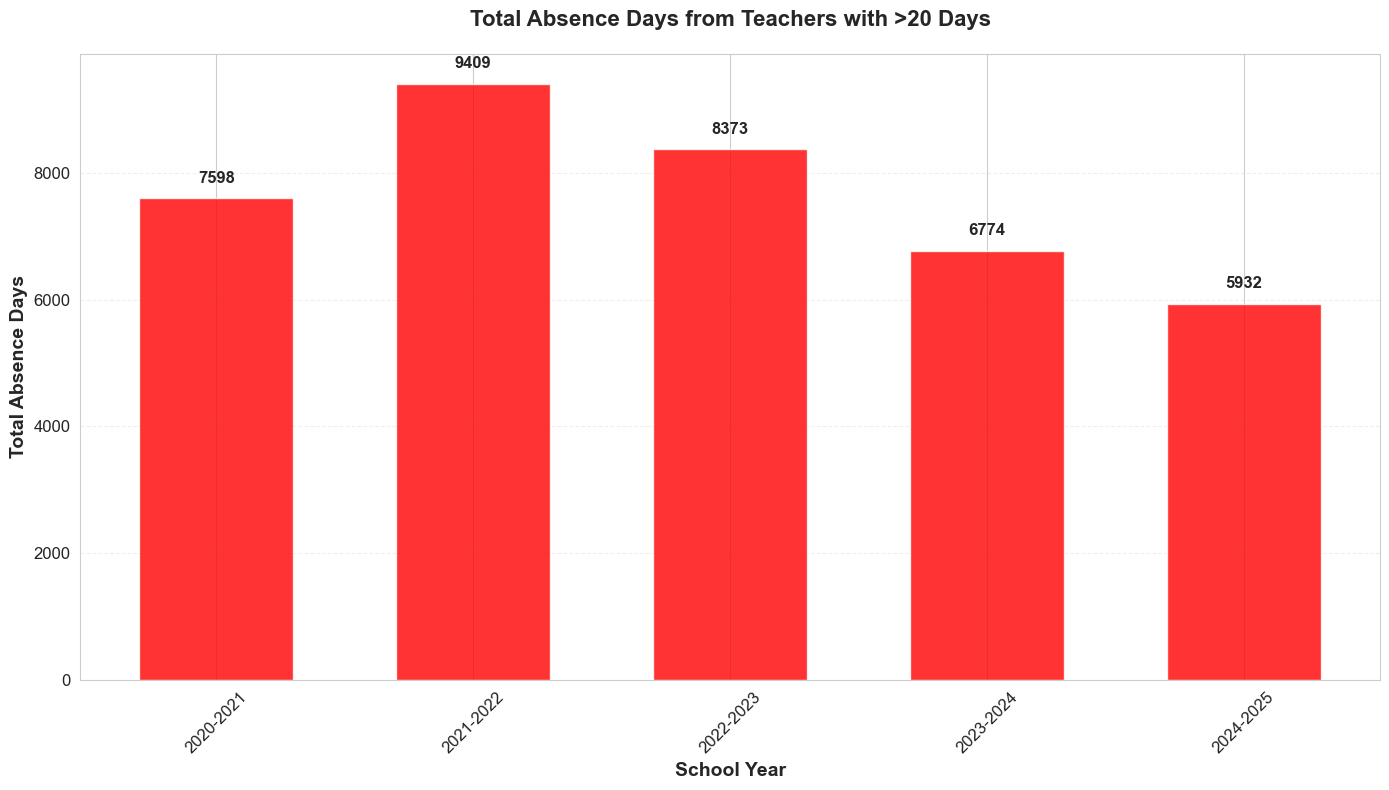

In [19]:
# Total Absence Days from Teachers with >20 Days
threshold = 20
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_days = [data['total_days_above'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.bar(years, total_days, color='red', width=0.6, alpha=0.8)
plt.title(f'Total Absence Days from Teachers with >20 Days', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Total Absence Days', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(total_days):
    plt.text(i, v + 200, f'{int(v)}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()



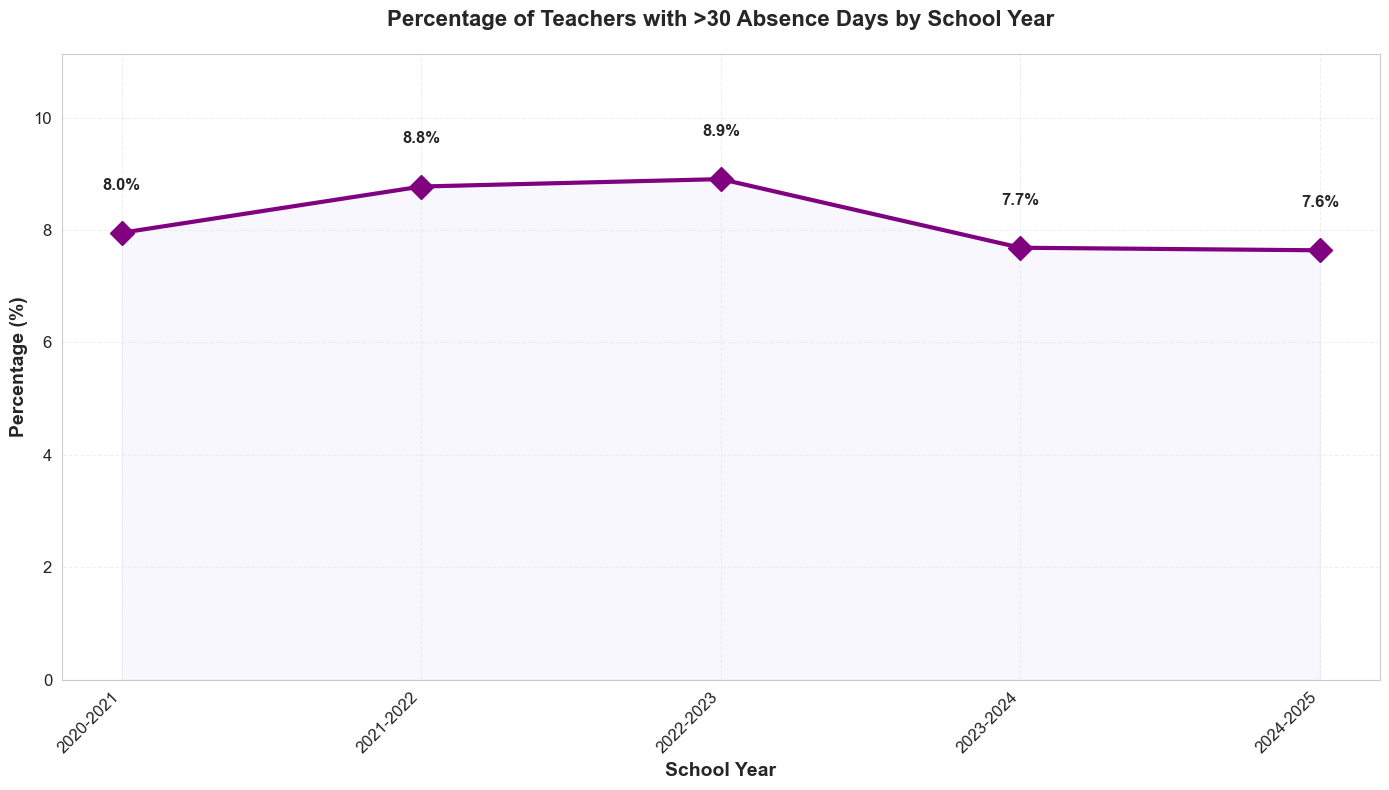

In [20]:
# Percentage of Teachers with >30 Absence Days by School Year
threshold = 30
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
pct_teachers = [data['pct_teachers'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.plot(years, pct_teachers, marker='D', linewidth=3, markersize=12, color='purple')
plt.fill_between(years, pct_teachers, alpha=0.3, color='lavender')

# Set y-axis limit to give more room for labels
max_pct = max(pct_teachers) if pct_teachers else 0
plt.ylim(0, max_pct * 1.25)  # Add 25% more space at top

plt.title(f'Percentage of Teachers with >30 Absence Days by School Year', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')

offset = max(max_pct * 0.08, 0.5)
for i, v in enumerate(pct_teachers):
    plt.text(i, v + offset, f'{v:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


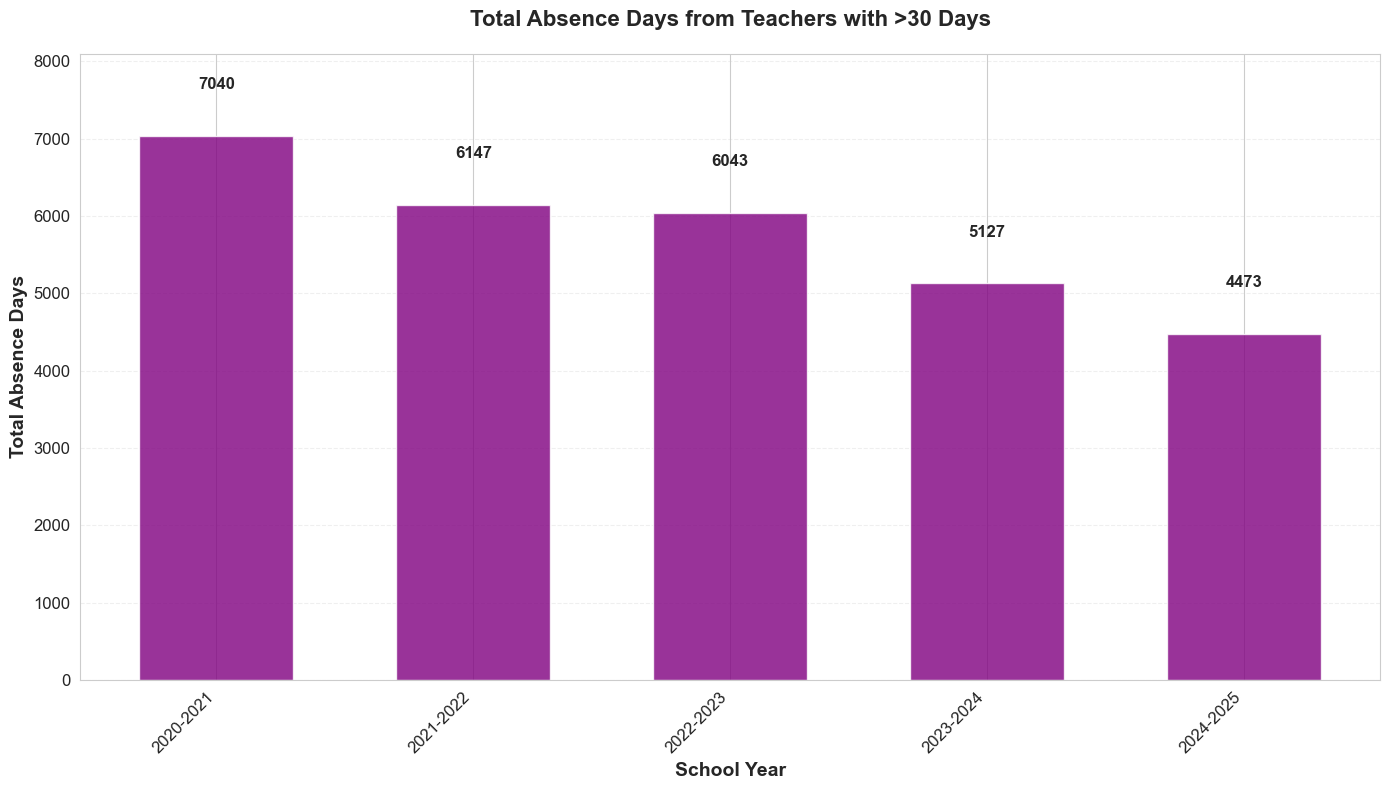

In [21]:
# Total Absence Days from Teachers with >30 Days
threshold = 30
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_days = [data['total_days_above'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.bar(years, total_days, color='purple', width=0.6, alpha=0.8)

max_value = max(total_days) if total_days else 0
plt.ylim(0, max_value * 1.15)

plt.title(f'Total Absence Days from Teachers with >30 Days', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Total Absence Days', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')

offset = max(max_value * 0.08, 150)
for i, v in enumerate(total_days):
    plt.text(i, v + offset, f'{int(v)}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


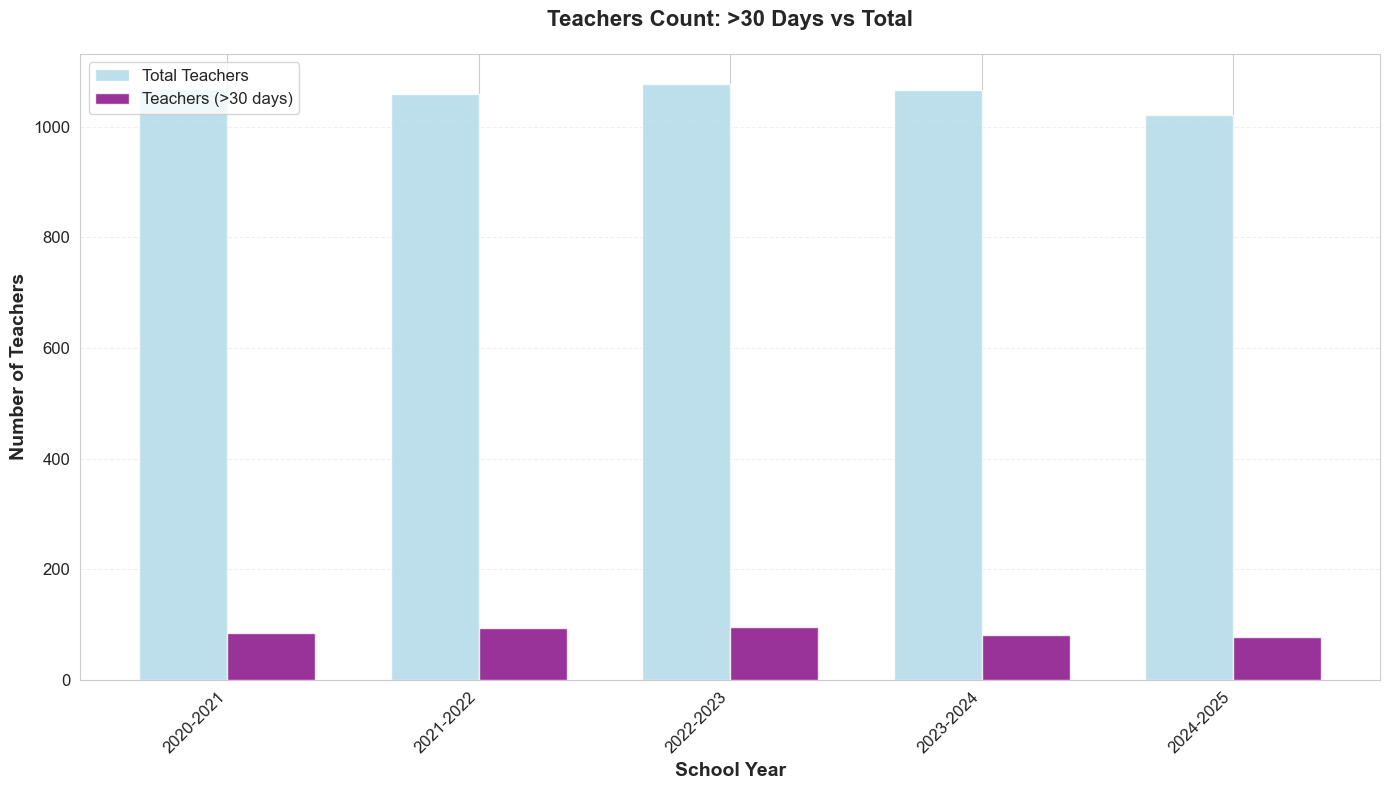

In [22]:
# Teachers Count: >30 Days vs Total
threshold = 30
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_teachers = [data['total_teachers'].get(year, 0) for year in years]
teachers_above = [data['teachers_above'].get(year, 0) for year in years]

x = np.arange(len(years))
width = 0.35

plt.figure(figsize=(14, 8))
plt.bar(x - width/2, total_teachers, width, label='Total Teachers', color='lightblue', alpha=0.8)
plt.bar(x + width/2, teachers_above, width, label=f'Teachers (>30 days)', color='purple', alpha=0.8)
plt.title(f'Teachers Count: >30 Days vs Total', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Number of Teachers', fontsize=14, fontweight='bold')
plt.xticks(x, years, rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


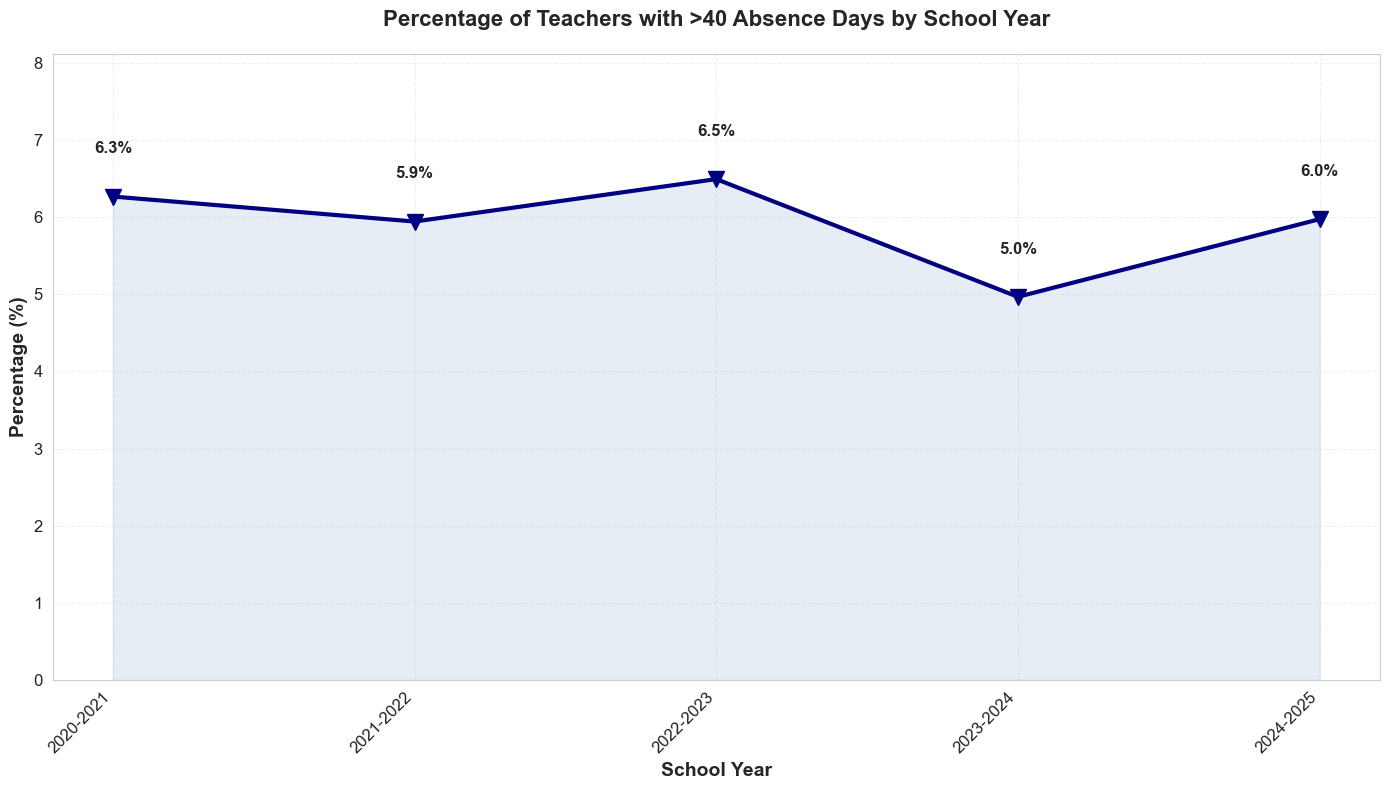

In [23]:
# Percentage of Teachers with >40 Absence Days by School Year
threshold = 40
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
pct_teachers = [data['pct_teachers'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.plot(years, pct_teachers, marker='v', linewidth=3, markersize=12, color='navy')
plt.fill_between(years, pct_teachers, alpha=0.3, color='lightsteelblue')

max_pct = max(pct_teachers) if pct_teachers else 0
plt.ylim(0, max_pct * 1.25)

plt.title(f'Percentage of Teachers with >40 Absence Days by School Year', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')

offset = max(max_pct * 0.08, 0.5)
for i, v in enumerate(pct_teachers):
    plt.text(i, v + offset, f'{v:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


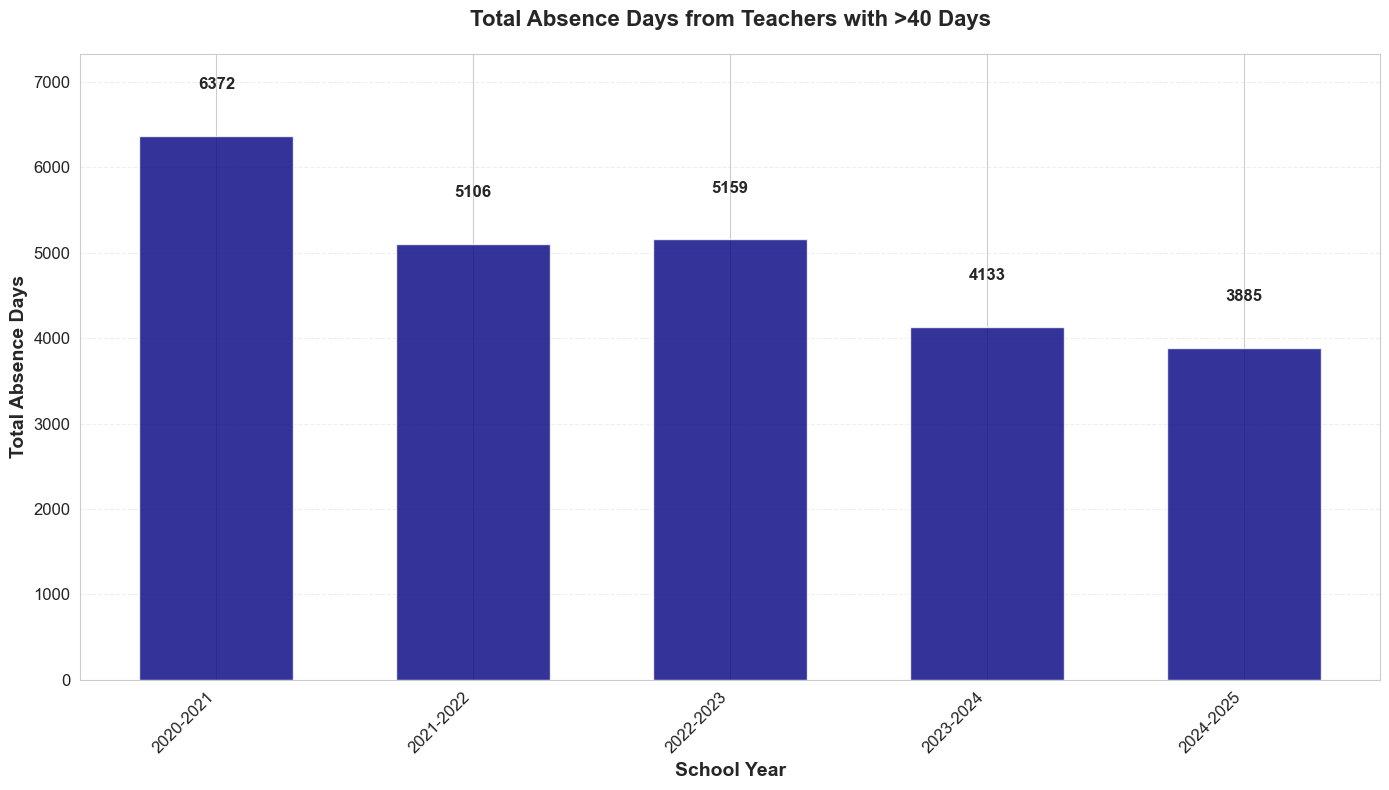

In [24]:
# Total Absence Days from Teachers with >40 Days
threshold = 40
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_days = [data['total_days_above'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.bar(years, total_days, color='navy', width=0.6, alpha=0.8)

max_value = max(total_days) if total_days else 0
plt.ylim(0, max_value * 1.15)

plt.title(f'Total Absence Days from Teachers with >40 Days', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Total Absence Days', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')

offset = max(max_value * 0.08, 100)
for i, v in enumerate(total_days):
    plt.text(i, v + offset, f'{int(v)}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


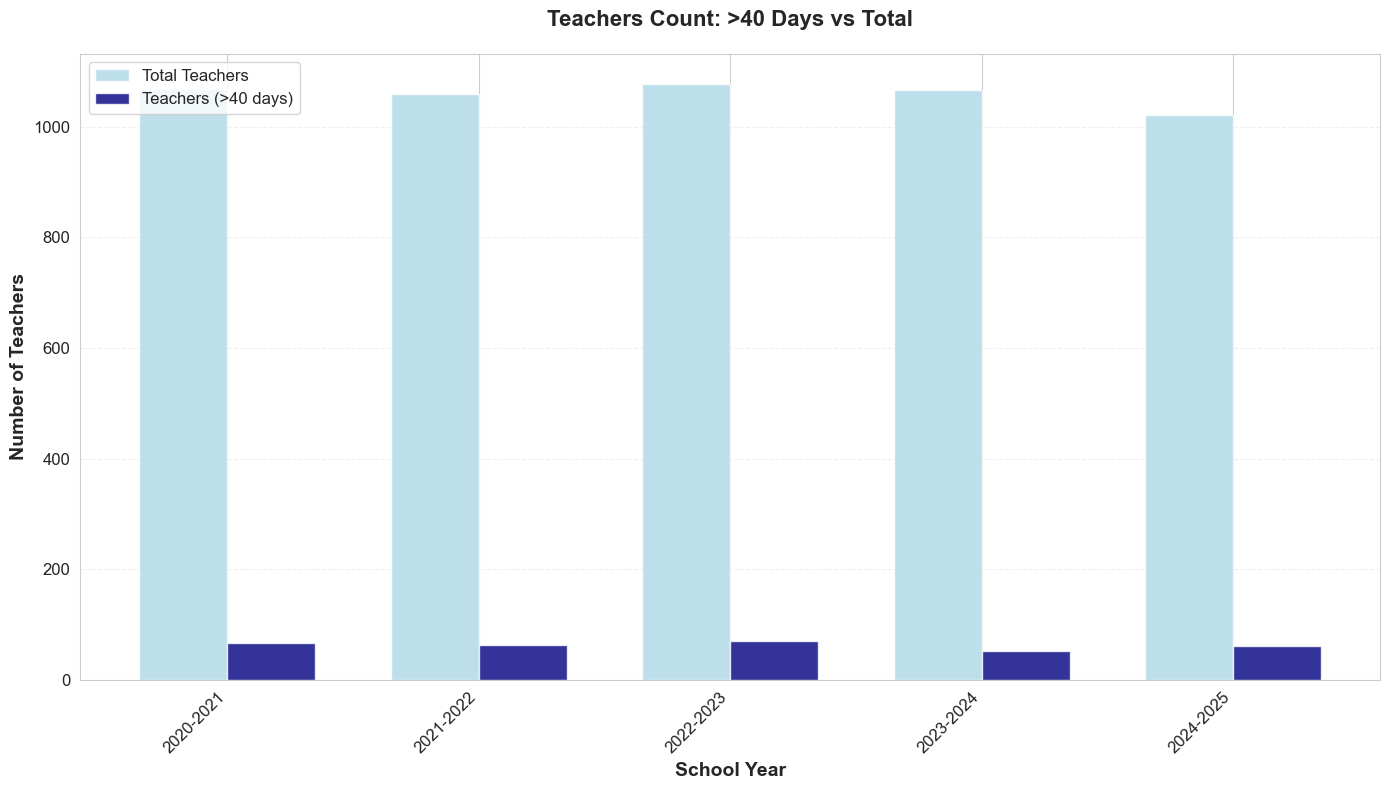

In [25]:
# Teachers Count: >40 Days vs Total
threshold = 40
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_teachers = [data['total_teachers'].get(year, 0) for year in years]
teachers_above = [data['teachers_above'].get(year, 0) for year in years]

x = np.arange(len(years))
width = 0.35

plt.figure(figsize=(14, 8))
plt.bar(x - width/2, total_teachers, width, label='Total Teachers', color='lightblue', alpha=0.8)
plt.bar(x + width/2, teachers_above, width, label=f'Teachers (>40 days)', color='navy', alpha=0.8)
plt.title(f'Teachers Count: >40 Days vs Total', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Number of Teachers', fontsize=14, fontweight='bold')
plt.xticks(x, years, rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


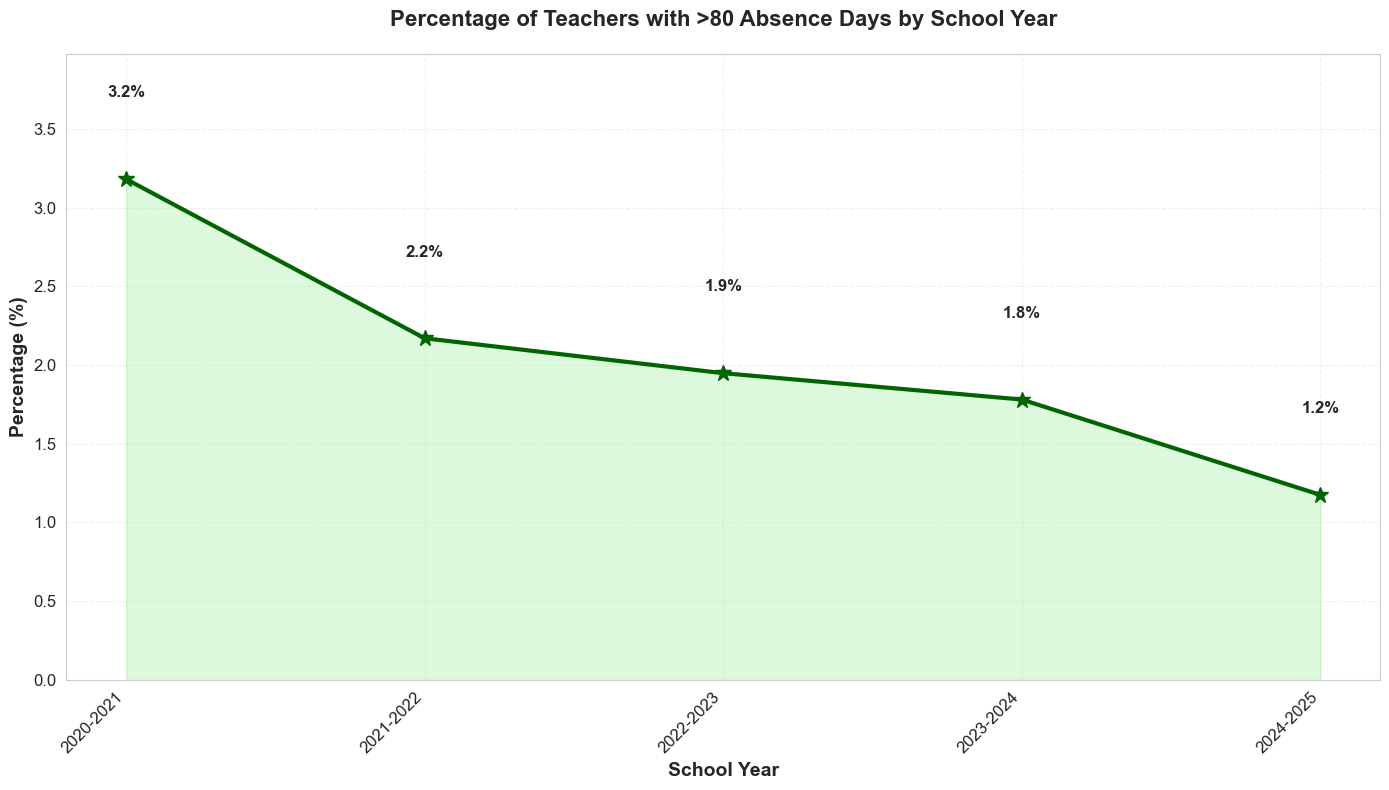

In [ ]:
# Percentage of Teachers with >80 Absence Days by School Year
threshold = 80
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
pct_teachers = [data['pct_teachers'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.plot(years, pct_teachers, marker='*', linewidth=3, markersize=12, color='darkgreen')
plt.fill_between(years, pct_teachers, alpha=0.3, color='lightgreen')

# Set y-axis limit to give more room for labels
max_pct = max(pct_teachers) if pct_teachers else 0
if max_pct == 0:
    plt.ylim(0, 1)  # Set minimum range when all values are 0
else:
    plt.ylim(0, max(max_pct * 1.25, 0.5))  # Add 25% more space at top, minimum 0.5%

plt.title(f'Percentage of Teachers with >80 Absence Days by School Year', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')  # Align rotated labels to the right
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')

# Position labels with better offset
for i, v in enumerate(pct_teachers):
    if v > 0:
        offset = max(max_pct * 0.08, 0.05)  # Use 8% of max or at least 0.05
        plt.text(i, v + offset, f'{v:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    else:
        # Show 0% label for zero values
        plt.text(i, 0.02, '0.0%', ha='center', va='bottom', fontsize=12, fontweight='bold', color='gray', alpha=0.7)
plt.tight_layout()
plt.show()

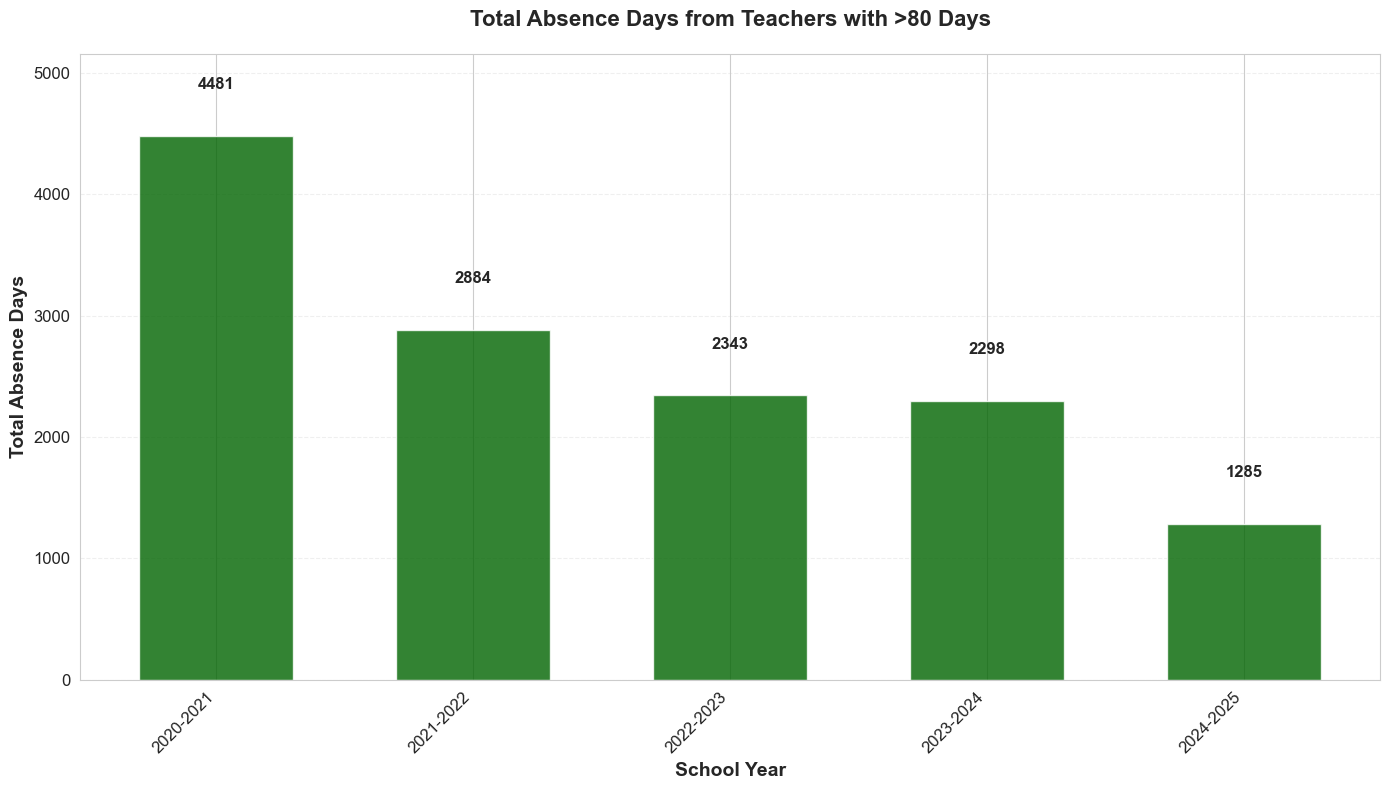

In [ ]:
# Total Absence Days from Teachers with >80 Days
threshold = 80
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_days = [data['total_days_above'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.bar(years, total_days, color='darkgreen', width=0.6, alpha=0.8)

# Set y-axis limit to give more room for labels
max_value = max(total_days) if total_days else 0
if max_value == 0:
    plt.ylim(0, 50)  # Set minimum range when all values are 0
else:
    plt.ylim(0, max_value * 1.15)  # Add 15% more space at top

plt.title(f'Total Absence Days from Teachers with >80 Days', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Total Absence Days', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')  # Align rotated labels to the right
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Position labels with better offset
for i, v in enumerate(total_days):
    if v > 0:
        offset = max(max_value * 0.08, 5)  # Use 8% of max or at least 5
        plt.text(i, v + offset, f'{int(v)}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    else:
        # Show 0 label for zero values
        plt.text(i, 2, '0', ha='center', va='bottom', fontsize=12, fontweight='bold', color='gray', alpha=0.7)
plt.tight_layout()
plt.show()

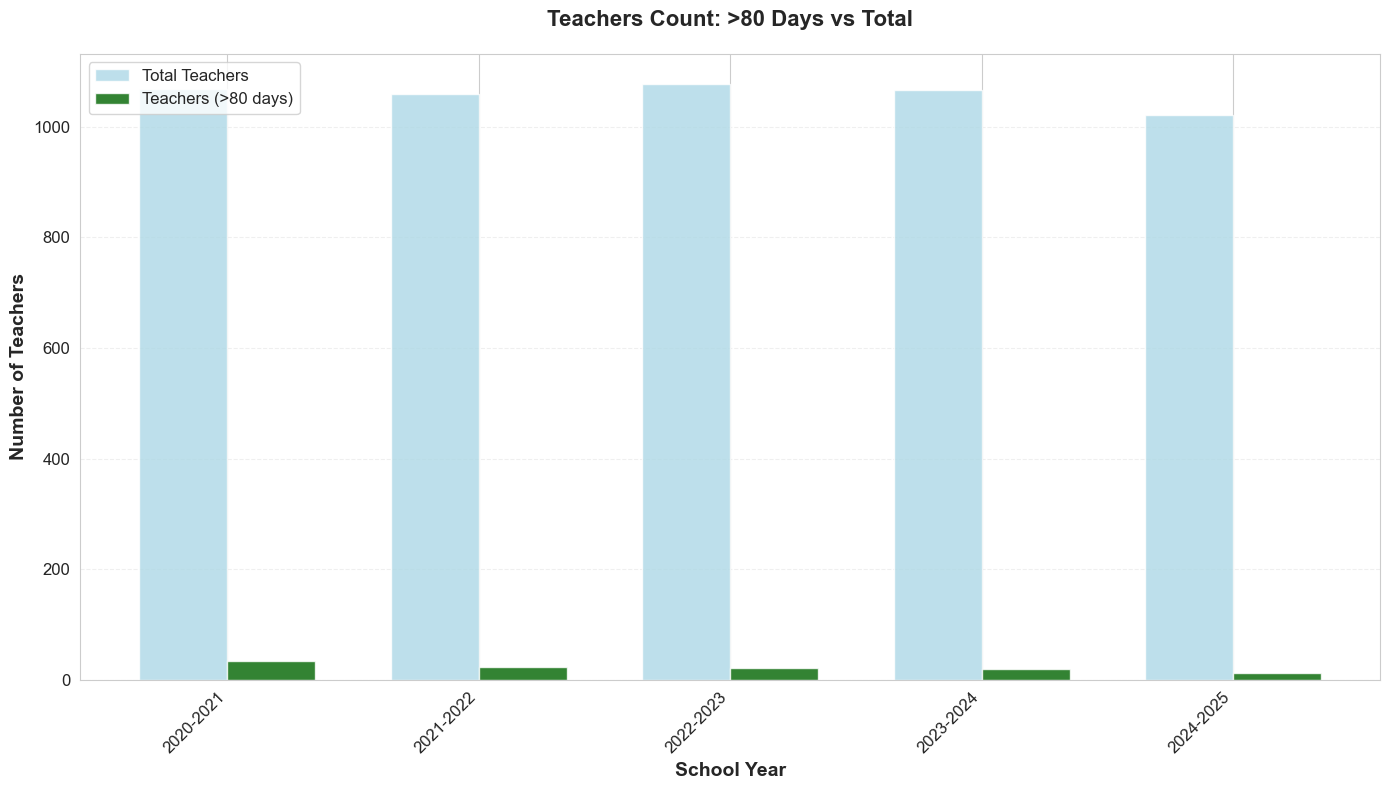

In [ ]:
# Teachers Count: >80 Days vs Total
threshold = 80
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_teachers = [data['total_teachers'].get(year, 0) for year in years]
teachers_above = [data['teachers_above'].get(year, 0) for year in years]

x = np.arange(len(years))
width = 0.35

plt.figure(figsize=(14, 8))
plt.bar(x - width/2, total_teachers, width, label='Total Teachers', color='lightblue', alpha=0.8)
plt.bar(x + width/2, teachers_above, width, label=f'Teachers (>80 days)', color='darkgreen', alpha=0.8)
plt.title(f'Teachers Count: >80 Days vs Total', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Number of Teachers', fontsize=14, fontweight='bold')
plt.xticks(x, years, rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

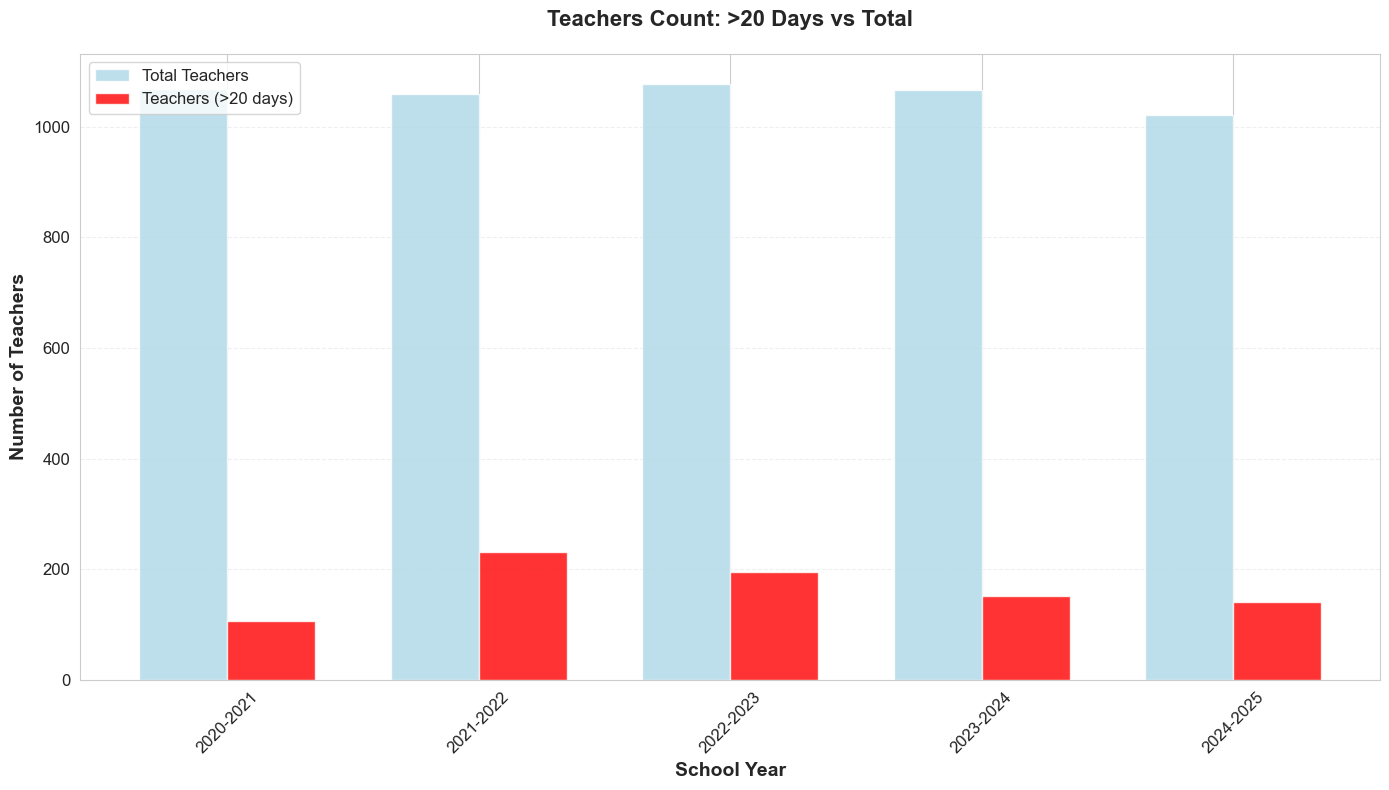

In [ ]:
# Teachers Count: >20 Days vs Total
threshold = 20
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_teachers = [data['total_teachers'].get(year, 0) for year in years]
teachers_above = [data['teachers_above'].get(year, 0) for year in years]

x = np.arange(len(years))
width = 0.35

plt.figure(figsize=(14, 8))
plt.bar(x - width/2, total_teachers, width, label='Total Teachers', color='lightblue', alpha=0.8)
plt.bar(x + width/2, teachers_above, width, label=f'Teachers (>20 days)', color='red', alpha=0.8)
plt.title(f'Teachers Count: >20 Days vs Total', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Number of Teachers', fontsize=14, fontweight='bold')
plt.xticks(x, years, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



# ABCover Profitability Analysis - Understanding the Business Model

## The Goal
Find the right combination of:
1. **Waiting Period** (e.g., >40 days, >50 days) - when coverage kicks in
2. **Payment Rate to ESS** (e.g., $100/day, $120/day) - what ABCover pays ESS per filled absence

## How It Works

### Step 1: ABCover Charges Schools 10% More
- Current ESS rate: $132.30/day
- ABCover rate to school: $145.53/day (10% increase)
- **ABCover's Revenue** = (New Rate - Old Rate) × Filled Absences
- This is the "premium" the school pays for coverage

### Step 2: ABCover Covers Catastrophic Absences
- Only covers absences **above the waiting period** (e.g., >40 days)
- Only pays for **filled absences** (90% fill rate)
- **ABCover's Cost** = Filled Reimbursable Days × Payment Rate to ESS

### Step 3: Calculate Profit/Loss
- **Profit/Loss** = Annual Revenue - ABCover Cost
- If positive = profitable ✅
- If negative = losing money ❌

## Example (from your manager's explanation)
- **Waiting Period**: >40 days
- **Reimbursable Days**: 2,419 (before fill rate)
- **Filled Reimbursable Days**: 2,177 (90% of 2,419)
- **Annual Revenue**: $235,587 (from 10% premium)
- **If paying ESS $100/day**: Cost = $217,700 → **Profit = $17,887** ✅
- **If paying ESS $145.53/day**: Cost = $316,833 → **Loss = -$81,246** ❌

The analysis below finds the best combinations!


In [ ]:
# ============================================================================
# ABCover Profitability Analysis
# Goal: Find the right combination of waiting period and payment rate to ESS
# that results in profitable coverage while only charging schools 10% more
# ============================================================================

# Constants
CURRENT_ESS_RATE = 132.30  # Current ESS replacement cost per day
FILL_RATE = 0.90  # ESS typically fills 90% of absences
PREMIUM_INCREASE = 0.10  # ABCover charges 10% more than ESS rate

# Calculate ABCover's rate to schools (10% increase)
ABCOVER_RATE_TO_SCHOOL = CURRENT_ESS_RATE * (1 + PREMIUM_INCREASE)

print("="*80)
print("ABCOVER PRICING STRUCTURE")
print("="*80)
print(f"Current ESS Rate: ${CURRENT_ESS_RATE:.2f}/day")
print(f"ABCover Rate to School (10% increase): ${ABCOVER_RATE_TO_SCHOOL:.2f}/day")
print(f"Premium per day: ${ABCOVER_RATE_TO_SCHOOL - CURRENT_ESS_RATE:.2f}/day")
print()

# Calculate total absences and filled absences (5-year average)
# From the data, we need to get total absences per year
total_absences_by_year = df.groupby('School Year').size()
avg_absences_per_year = total_absences_by_year.mean()
filled_absences_per_year = avg_absences_per_year * FILL_RATE

print("="*80)
print("ANNUAL ABSENCE STATISTICS (5-Year Average)")
print("="*80)
print(f"Total Absences per Year: {avg_absences_per_year:,.0f}")
print(f"Filled Absences per Year (90% fill rate): {filled_absences_per_year:,.0f}")
print()

# Calculate ABCover's annual revenue (premium from school)
annual_revenue = filled_absences_per_year * (ABCOVER_RATE_TO_SCHOOL - CURRENT_ESS_RATE)
print(f"ABCover Annual Revenue (Premium): ${annual_revenue:,.2f}")
print()

# Now analyze different waiting period thresholds and payment rates
print("="*80)
print("PROFITABILITY ANALYSIS")
print("="*80)
print("Testing different combinations of:")
print("  - Waiting Period Threshold (days)")
print("  - Payment Rate to ESS (per filled absence day)")
print()

# Get reimbursable days for different thresholds (from 5-year average)
# Use only thresholds that exist in summary_tables
available_thresholds = [t for t in [30, 40, 50, 60] if t in summary_tables]
payment_rates_to_test = [80, 90, 100, 110, 120, 130, 140, 145.53]  # Different rates ABCover could pay ESS

# Get reimbursable days from summary tables (5-year average)
results_matrix = []

for threshold in available_thresholds:
    if threshold in summary_tables:
        # Get 5-year average reimbursable days
        avg_row = summary_tables[threshold][summary_tables[threshold]['School Year'] == '5-Year Avg']
        if len(avg_row) > 0:
            reimbursable_days = avg_row['Reimbursable Days'].values[0]
            
            # Apply 90% fill rate to reimbursable days
            filled_reimbursable_days = reimbursable_days * FILL_RATE
            
            for payment_rate in payment_rates_to_test:
                # Calculate ABCover's cost (what they pay to ESS)
                abcover_cost = filled_reimbursable_days * payment_rate
                
                # Calculate profit/loss
                profit_loss = annual_revenue - abcover_cost
                
                # Calculate profit margin
                profit_margin_pct = (profit_loss / annual_revenue * 100) if annual_revenue > 0 else 0
                
                results_matrix.append({
                    'Waiting Period': f'>{threshold} days',
                    'Reimbursable Days (before fill rate)': round(reimbursable_days, 1),
                    'Filled Reimbursable Days (90% fill)': round(filled_reimbursable_days, 1),
                    'Payment Rate to ESS': f'${payment_rate:.2f}',
                    'ABCover Cost': f'${abcover_cost:,.2f}',
                    'Annual Revenue': f'${annual_revenue:,.2f}',
                    'Profit/Loss': f'${profit_loss:,.2f}',
                    'Profit Margin %': f'{profit_margin_pct:.1f}%'
                })

# Create results DataFrame
results_df = pd.DataFrame(results_matrix)

# Display results
print("\n" + "="*120)
print("PROFITABILITY MATRIX - All Scenarios")
print("="*120)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
print(results_df.to_string(index=False))
print()

# Highlight profitable scenarios
profitable_scenarios = results_df[results_df['Profit/Loss'].str.replace('$', '').str.replace(',', '').astype(float) > 0]
print("\n" + "="*120)
print("PROFITABLE SCENARIOS (Profit > $0)")
print("="*120)
if len(profitable_scenarios) > 0:
    print(profitable_scenarios.to_string(index=False))
    print(f"\nTotal Profitable Scenarios: {len(profitable_scenarios)}")
else:
    print("No profitable scenarios found with current parameters.")
print()

# Find optimal scenarios (highest profit)
print("="*120)
print("TOP 10 MOST PROFITABLE SCENARIOS")
print("="*120)
# Convert profit/loss to numeric for sorting
results_df['Profit_Loss_Numeric'] = results_df['Profit/Loss'].str.replace('$', '').str.replace(',', '').astype(float)
top_scenarios = results_df.nlargest(10, 'Profit_Loss_Numeric')[['Waiting Period', 'Payment Rate to ESS', 
                                                                 'Filled Reimbursable Days (90% fill)',
                                                                 'ABCover Cost', 'Annual Revenue', 
                                                                 'Profit/Loss', 'Profit Margin %']]
print(top_scenarios.to_string(index=False))


ABCOVER PRICING STRUCTURE
Current ESS Rate: $132.30/day
ABCover Rate to School (10% increase): $145.53/day
Premium per day: $13.23/day

ANNUAL ABSENCE STATISTICS (5-Year Average)
Total Absences per Year: 19,824
Filled Absences per Year (90% fill rate): 17,842

ABCover Annual Revenue (Premium): $236,044.37

PROFITABILITY ANALYSIS
Testing different combinations of:
  - Waiting Period Threshold (days)
  - Payment Rate to ESS (per filled absence day)


PROFITABILITY MATRIX - All Scenarios
Waiting Period  Reimbursable Days (before fill rate)  Filled Reimbursable Days (90% fill) Payment Rate to ESS ABCover Cost Annual Revenue  Profit/Loss Profit Margin %
      >30 days                                3162.7                               2846.4              $80.00  $227,714.40    $236,044.37    $8,329.97            3.5%
      >30 days                                3162.7                               2846.4              $90.00  $256,178.70    $236,044.37  $-20,134.33           -8.5%
      >30